In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
#Importing all the neccessary libraries
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, neighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import scikitplot.metrics as sciplot
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import math
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm


<b> The immediate code block below does the following things :</b>
<br>
<ol>
    <li>Load the Amazon dataset.</li>

<li>Classify the reviews initially based on their score rating and give them a 'Positve' or a 'Negative' tag.</li>
<li>Remove duplicate/redundant datas.</li>
<li>Get an idea of how much percentage data were actually duplicates.</li>
<li>Plot a histogram which will display the distribution of the number of positive and negative reviews after de-duplication.</li>
</ol>

In [3]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('/kaggle/input/amazon-fine-food-reviews/database.sqlite') 

#Filter only positive and negative reviews. Do nbot consider reviews with score = 3.
#not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, connection_sqlobject)

#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

#Display information about the dataset before the removal of duplicate data.
print("The shape of the filtered matrix : {}".format(filtered_data.shape))
print("The median score values : {}".format(filtered_data['Score'].mean()))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

#Removing duplicate entries based on past knowledge.
filtered_duplicates=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
final_data=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

#Display information about the dataset after the removal of duplicate data.
print("\nThe shape of the data matrix after deduplication : {}".format(final_data.shape))
print("The median score values after deduplication : {}".format(final_data['Score'].mean()))
print("The number of positive and negative reviews after the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())

#Checking to see how much % of data still remains.
print("\nChecking to see how much percentage of data still remains.")
retained_per = (final_data['SentimentPolarity'].size*1.0)/(filtered_data['SentimentPolarity'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))

#Display the first 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.
print("\nFirst 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.")
final_data.head(5)

The shape of the filtered matrix : (525814, 12)
The median score values : 4.27914813983652
The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative     82037
Name: SentimentPolarity, dtype: int64

The shape of the data matrix after deduplication : (364171, 12)
The median score values after deduplication : 4.27579626054793
The number of positive and negative reviews after the removal of duplicate data.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64

Checking to see how much percentage of data still remains.
Percentage of redundant data removed : 30.741478926008057
Percentage of original data retained : 69.25852107399194

First 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


<b>In this code block :</b><br>
<ol>
<li>I am creating a copy of the final_data dataset called 'sampled_dataset' by dropping the unwanted columns that we don't need for this problem.</li>
<li>Sorting the data according to time, such that the oldest reviews are displayed at the top and the latest reviews are displayed at the bottom.</li>
<li>Displaying information about the number of postive and negative reviews in the sampled dataset, using a Histogram.</li>
    </ol>

The shape of the sampled dataset after dropping unwanted columns :  (364171, 4)

First 10 rows of the sampled_dataset.


,Time,Text,SentimentPolarity,Class_Labels
0,1351209600,I just got this coffee a few days ago. I had c...,Negative,0
1,1351209600,Very pleased with the quality of the espresso....,Positive,1
2,1351209600,Bought this with my new Oster Belgium waffle m...,Positive,1
3,1351209600,We drink a lot of tea... from all over the wor...,Negative,0
4,1351209600,I have always bought my pure vanilla extract i...,Positive,1
5,1351209600,"From the label on the Cadbury Screme Egg: ""ALL...",Positive,1
6,1351209600,"Best soup mix I've tried. I love making soup, ...",Positive,1
7,1351209600,try it & we shared with the familys/all han th...,Positive,1
8,1351209600,If you like butter flavor this is the best mic...,Positive,1
9,1351209600,I love all sorts of teas. My friends know this...,Positive,1


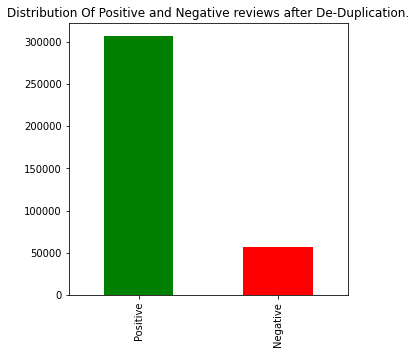

In [4]:
'''Creating a sampled dataset dropping the unwanted columns that we don't need for this problem, from the actual dataset.'''
#Creating a subset of the "final_data" table with randomly selecting 360000 samples
#sampled_dataset = final_data.sample(n=360000, replace=False, random_state=0).reset_index()
#print("\nThe shape of the sampled dataset : ", sampled_dataset.shape)

#Dropping unwanted columns for now.
sampled_dataset=final_data.drop(labels=['Id','ProductId', 'UserId', 'Score', 'ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator','Summary'], axis=1)
print("The shape of the sampled dataset after dropping unwanted columns : ", sampled_dataset.shape)

#Sorting data according to Time in ascending order => Time Based Splitting Step 1.
sampled_dataset=sampled_dataset.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
sampled_dataset = sampled_dataset.reset_index()
sampled_dataset=sampled_dataset.drop(labels=['index'], axis=1)

#Display distribution of Postive and Negative reviews in a bar graph
sampled_dataset["SentimentPolarity"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews after De-Duplication.',figsize=(5,5))
sampled_dataset.head(5)

#Display the first 10 rows of the sampled_dataset (All the reviews are arranged according to time)
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)

<b>In this code block :</b><br>
<ol>
<li>We define two functions which will remove the HTML tags and punctuations from each review.</li>
<li>At the end of this code block, each review will contain texts which will only contain alphabetical strings.</li>
<li>We will apply techniques such as stemming and stopwords removal.</li>
<li>We will create two columns in the sampled dataset - 'CleanedText' and 'RemovedHTML'.</li>
<li>'CleanedText' column will basically contain the data corpus after stemming the each reviews and removing stopwords from each review. We will use this for our Bag of Word model.</li>
<li>'RemovedHTML' column will contain the data corpus from which only the HTML tags and punctuations are removed. We will use this column for our TF-IDF model, Average Word2Vec model and TF-IDF weighted average Word2Vec model.</li>
<li>Store the final table in a dataset called 'sampled_dataset' for future use.</li>
</ol>

In [5]:
# https://stackoverflow.com/a/47091490/4084039
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
import re

#Expand the reviews x is aninput string of any length. Convert all the words to lower case
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x


#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def removeNumbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return (sentence)

#Remove URL from sentences.
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)

#https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
#Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc.
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return cleaned_text

#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['no', 'nor', 'not'])
custom_stopwords = default_stopwords - remove_not

In [6]:
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
 
count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
stemed_word=' '

for review in tqdm(final_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(sno.stem(cleaned_words.lower()))                                   
            filtered_sentence.append(stemed_word)
            if (final_data['SentimentPolarity'].values)[count] == 'Positive': 
                all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
            if(final_data['SentimentPolarity'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
#Save the list of positive words and negative words
import pickle
with open('all_positive_words.pkl', 'wb') as file:
    pickle.dump(all_positive_words, file)
    
with open('all_negative_words.pkl', 'wb') as file:
    pickle.dump(all_negative_words, file)
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))

#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews

100%|██████████| 364171/364171 [09:42<00:00, 625.60it/s]


The length of the data corpus is : 364171


In [7]:
## Similartly you can do preprocessing for summary summary also.
import warnings
warnings.filterwarnings("ignore")

preprocessed_summary = [] #Store all the processed summary
 
count=0     #Iterator to iterate through the list of summarys and check if a given summary belongs to the positive or negative class
string=' '    
stemed_word=' '

for summary in tqdm(final_data['Summary'].values):
    filtered_sentence=[]
    summary = decontracted(summary)
    summary = removeNumbers(summary)
    summary = removeHtml(summary)
    summary = removeURL(summary)
    summary = removePunctuations(summary)
    summary = removePatterns(summary)
    
    for cleaned_words in summary.split():
        if(2<len(cleaned_words)<16):
            stemed_word=(sno.stem(cleaned_words.lower()))
            filtered_sentence.append(stemed_word)
    summary = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_summary.append(summary.strip()) #Data corpus contaning cleaned summarys from the whole dataset
    count+=1
    
#Adding a column of CleanedSummary to the table final which stores the data_corpus after pre-processing the summarys 
final_data['CleanedSummary']=preprocessed_summary

#Combing the reviews with summary for each sentence
final_data['Combined_Reviews'] = final_data['CleanedText'].values + " " + final_data['CleanedSummary'].values 

#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
final_data.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True)

print("File is saved as 'totally_processed_DB.sqlite'")

100%|██████████| 364171/364171 [00:41<00:00, 8689.17it/s]


File is saved as 'totally_processed_DB.sqlite'


## Featurization

In [8]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite') 
processed_db = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

# To improve the speed of the model we have taken less amount of data.(100k, 30k, 40k) supposed to be taken.
#Split the data into train and test set. The train set will contain 10K old reviews. The test set has 3k newer reviews. We will also use 4K latest reviews as a calibration dataset to calibrate our model. 
#X_train = processed_db['CleanedText'].iloc[150000:250000,] ; y_train = processed_db['Class_Labels'].iloc[150000:250000,]
#X_test = processed_db['CleanedText'].iloc[250000:280000,] ; y_test = processed_db['Class_Labels'].iloc[250000:280000,]
#X_calib = processed_db['CleanedText'].iloc[280000:320000,] ; y_calib = processed_db['Class_Labels'].iloc[280000:320000,]
X_train = processed_db['CleanedText'].iloc[15000:25000,] ; y_train = processed_db['Class_Labels'].iloc[15000:25000,]
X_test = processed_db['CleanedText'].iloc[25000:28000,] ; y_test = processed_db['Class_Labels'].iloc[25000:28000,]
X_calib = processed_db['CleanedText'].iloc[28000:32000,] ; y_calib = processed_db['Class_Labels'].iloc[28000:32000,]

processed_db.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels,CleanedText,CleanedSummary,Combined_Reviews
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1,bought sever vital can dog food product found ...,good qualiti dog food,bought sever vital can dog food product found ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0,product arriv label jumbo salt peanut peanut a...,not advertis,product arriv label jumbo salt peanut peanut a...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1,confect around centuri light pillowi citrus ge...,delight say all,confect around centuri light pillowi citrus ge...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0,look secret ingredi robitussin believ found go...,cough medicin,look secret ingredi robitussin believ found go...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1,great taffi great price wide assort yummi taff...,great taffi,great taffi great price wide assort yummi taff...


<AxesSubplot:title={'center':'Distribution Of Positive and Negative reviews in 150K datapoints.'}>

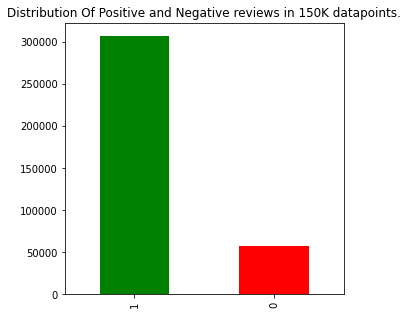

In [9]:
#Display distribution of Postive and Negative reviews in a bar graph
processed_db["Class_Labels"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews in 150K datapoints.',figsize=(5,5))

### BAG OF WORDS

In [10]:
#Initializing the BOW constructor
cv_object = CountVectorizer(min_df=10, max_features=50000, dtype='float')
cv_object.fit(X_train)

#Print names of some random features
print("Some feature names ", cv_object.get_feature_names()[100:110])
print('='*215)

#Creating the BOW matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus...")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)
X_calib_vectors = cv_object.transform(X_calib)

print("\nThe type of count vectorizer ",type(X_train_vectors))
print("The shape of our train BOW vectorizer ",X_train_vectors.get_shape())
print("The shape of our test BOW vectorizer ",X_test_vectors.get_shape())
print("The number of unique words ", X_train_vectors.get_shape()[1])

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_BOW.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)

with open('y_train_BOW.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('X_test_BOW.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_test_BOW.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_BOW.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_BOW.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

Some feature names  ['appet', 'appetit', 'appl', 'appli', 'appreci', 'approach', 'appropri', 'approv', 'approx', 'approxim']

Creating the BOW vectors using the cleaned corpus...

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our train BOW vectorizer  (10000, 2814)
The shape of our test BOW vectorizer  (3000, 2814)
The number of unique words  2814


### Bi-Grams and n-Grams.

In [11]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

#Initializing the Bi-Gram constructor
cv_object = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=50000, dtype='float')             #min_df=10: ignore terms that have a document frequency strictly lower than 10.
cv_object.fit(X_train)                                                                                  #max_features=50000: top 50000 features

#Print names of some random features
print("Some feature names ", cv_object.get_feature_names()[100:110])
print('='*215)

#Creating the Bi-Gram matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the Bi-Gram vectors using the cleaned corpus...")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)

print("\nThe type of count vectorizer ",type(X_train_vectors))
print("The shape of our train BiGram vectorizer ",X_train_vectors.get_shape())
print("The shape of our test BiGram vectorizer ",X_test_vectors.get_shape())
print("The number of unique words ", X_train_vectors.get_shape()[1])

#Save the bi grams train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_BiGrm.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)

with open('y_train_BiGrm.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('X_test_BiGrm.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_test_BiGrm.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_BiGrm.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_BiGrm.pkl', 'wb') as file:
    pickle.dump(y_calib, file)


Some feature names  ['ala', 'alcohol', 'ale', 'allerg', 'allerg reaction', 'allergen', 'allergi', 'allow', 'almond', 'almond milk']

Creating the Bi-Gram vectors using the cleaned corpus...

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our train BiGram vectorizer  (10000, 6411)
The shape of our test BiGram vectorizer  (3000, 6411)
The number of unique words  6411


### TF-IDF

In [12]:
#Initializing the TF-IDF constructor
tf_idf_obj = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=50000, dtype='float').fit(X_train) #min_df=10: ignore terms that have a document frequency strictly lower than 10.
                                                                                                           #max_features=50000: top 50000 features
#Print names of some random features
print("Some feature names ", tf_idf_obj.get_feature_names()[100:110])
print('='*215)

#Creating the TF-IDF matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the TF-IDF vectors using the cleaned corpus...")
X_train_vectors = tf_idf_obj.transform(X_train)
X_test_vectors = tf_idf_obj.transform(X_test)
X_calib_vectors = tf_idf_obj.transform(X_calib)

print("\nThe type of count vectorizer ",type(X_train_vectors))
print("The shape of our train BiGram vectorizer ",X_train_vectors.get_shape())
print("The shape of our test BiGram vectorizer ",X_test_vectors.get_shape())
print("The number of unique words including both unigrams and bigrams. ", X_train_vectors.get_shape()[1])

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

Some feature names  ['ala', 'alcohol', 'ale', 'allerg', 'allerg reaction', 'allergen', 'allergi', 'allow', 'almond', 'almond milk']

Creating the TF-IDF vectors using the cleaned corpus...

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our train BiGram vectorizer  (10000, 6411)
The shape of our test BiGram vectorizer  (3000, 6411)
The number of unique words including both unigrams and bigrams.  6411


### Word2Vec

In [13]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in processed_db['CleanedText'].values:
    list_of_sentance.append(sentance.split())

In [14]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*215)
print(w2v_model.wv.most_similar('worst'))
'''
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])
'''

[('terrif', 0.8621993660926819), ('good', 0.8483864665031433), ('fantast', 0.8475948572158813), ('awesom', 0.8220280408859253), ('excel', 0.8205869793891907), ('wonder', 0.7998706102371216), ('nice', 0.7711883783340454), ('perfect', 0.7709812521934509), ('fabul', 0.7161368727684021), ('decent', 0.6610563397407532)]
[('nastiest', 0.8737514615058899), ('greatest', 0.755973219871521), ('disgust', 0.7404711246490479), ('best', 0.7200688123703003), ('horribl', 0.7136557102203369), ('tastiest', 0.7072315812110901), ('horrid', 0.7035999894142151), ('nicest', 0.6995272040367126), ('terribl', 0.6792141199111938), ('weakest', 0.6682063341140747)]


'\nw2v_words = list(w2v_model.wv.vocab)\nprint("number of words that occured minimum 5 times ",len(w2v_words))\nprint("sample words ", w2v_words[0:50])\n'

### Converting text into vectors using Avg W2V, TFIDF-W2V

#### Avg W2V

In [15]:
#Build a Word2Vec model on train data and use this to vectorize the test and cv data.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split()) #Returns a list of words for each sentence for all the reviews
print("The size of the Word2Vec text corpus : ",len(word2vec_corpus))

#word2vec_model=Word2Vec(word2vec_corpus,min_count=5,vector_size=50, workers=-1)


word2vec_model=Word2Vec(sentences=word2vec_corpus, vector_size=200, min_count=5, workers=-1) #min_count = 5 considers only those words for our model which occurs atleast 5 times
word2vec_words = list(word2vec_model.wv.index_to_key) #print("\nThe number of words that occured minimum 5 times : ",len(word2vec_words))

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_w2v(dataset, word2vec_model, word2vec_words):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split()) 
    
    # Creating average Word2Vec model by computing the average word2vec for each review.
    sent_vectors = []; #The average word2vec for each sentence/review will be stored in this list
    for sentence in tqdm(word2vec_corpus): #For each review
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        count_words =0; #This will store the count of the words with a valid vector in each review text
        for word in sentence: #For each word in a given review.
            if word in word2vec_words:
                word_vectors = word2vec_model.wv[word] #Creating a vector(numpy array of 100 dimensions) for each word.
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    #print("\nThe length of the sentence vectors :",len(sent_vectors))
    #print("\nSize of each vector : ",len(sent_vectors[0]))
    sent_vectors = np.array(sent_vectors)
    return sent_vectors


X_train_vectors = vectorize_w2v(X_train, word2vec_model, word2vec_words)
X_test_vectors = vectorize_w2v(X_test, word2vec_model, word2vec_words)
X_calib_vectors = vectorize_w2v(X_calib, word2vec_model, word2vec_words)


print("The shape of our Avg Word2Vec train vectorizer ",X_train_vectors.shape)
print("The shape of our Avg Word2Vec test vectorizer ",X_test_vectors.shape)
print("The shape of our Avg Word2Vec calibration vectorizer ",X_calib_vectors.shape)

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_W2V.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_W2V.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_W2V.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_W2V.pkl', 'wb') as file:
    pickle.dump(y_test, file)

with open('X_calib_W2V.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_W2V.pkl', 'wb') as file:
    pickle.dump(y_calib, file)


The size of the Word2Vec text corpus :  10000


100%|██████████| 4000/4000 [00:02<00:00, 1379.18it/s]


The shape of our Avg Word2Vec train vectorizer  (10000, 200)
The shape of our Avg Word2Vec test vectorizer  (3000, 200)
The shape of our Avg Word2Vec calibration vectorizer  (4000, 200)


#### TFIDF weighted W2v

In [16]:
#Build a word2vec model using the train data and use this model to vectorize test and cv data.
#word2vec_corpus will store the list of words for each review.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split())

#min_count = 5 considers only those words which occurs atleast 5 times
word2vec_model=Word2Vec(sentences=word2vec_corpus, vector_size=200, min_count=5, workers=8)
word2vec_words = list(word2vec_model.wv.index_to_key)

#Initializing the TF-IDF contructor with review texts. HTML tags and punctuations are removed. Stopwords are preserved.
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_tfidf_w2v(dataset, tf_idf_object, word2vec_model, word2vec_words):

    #word2vec_corpus will store the list of words for each review.
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split())

    #Use the earlier TF-IDF object to vectorize test and cv data.
    tf_idf_matrix = tf_idf_object.transform(dataset)
    tfidf_features = tf_idf_object.get_feature_names() 
    
    # We are building a dictionary with words as a key, and the idfs as value
    dictionary = dict(zip(tf_idf_object.get_feature_names(), list(tf_idf_object.idf_)))

    #Algorithm for finding the TF-IDF weighted average word2vec vectors.
    tfidf_sent_vectors = []; #The tfidf-w2v for each sentence/review will stored in this list
    row=0;
    for sentence in tqdm(word2vec_corpus): #For each review/sentence 
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        weight_sum = 0; #This will store the count of the words with a valid vector in each review text.
        for word in sentence: #For each word in a review/sentence
            if((word in word2vec_words) and (word in tfidf_features)):
                word_vectors = word2vec_model.wv[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence)) #tf_idf = tf_idf_matrix[row, tfidf_features.index(word)] #tf_idfidf of a word in a sentence/review       
                sent_vec += (word_vectors * tf_idf)                            #dictionary[word] = idf value of word in whole courpus  # sent.count(word) = tf valeus of word in this review                          
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    tfidf_sent_vectors = np.array(tfidf_sent_vectors)
    return tfidf_sent_vectors

#Converting the words to word vector representation.
X_train_vectors = vectorize_tfidf_w2v(X_train, tf_idf_object, word2vec_model, word2vec_words)
X_test_vectors = vectorize_tfidf_w2v(X_test, tf_idf_object, word2vec_model, word2vec_words)
X_calib_vectors = vectorize_tfidf_w2v(X_calib, tf_idf_object, word2vec_model, word2vec_words)

print("The shape of our TF-IDF Avg Word2Vec train vectorizer ",X_train_vectors.shape)
print("The shape of our TF-IDF Avg Word2Vec test vectorizer ",X_test_vectors.shape)
print("The shape of our TF-IDF Avg Word2Vec calibration vectorizer ",X_calib_vectors.shape)
                                           
#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

100%|██████████| 4000/4000 [00:25<00:00, 154.46it/s]


The shape of our TF-IDF Avg Word2Vec train vectorizer  (10000, 200)
The shape of our TF-IDF Avg Word2Vec test vectorizer  (3000, 200)
The shape of our TF-IDF Avg Word2Vec calibration vectorizer  (4000, 200)


<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

## Applying Logistic Regression

In [17]:

#This function is used to standardize a data matrix.
def standardize(data, with_mean):
    '''Function used to column standardize any given matrix'''
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler(with_mean=with_mean)
    std=scalar.fit_transform(data)
    return (std)

#This function is used to get the top features for each of the model for each of the featurizations.
def top_features(best_estimator, X_train_standardized, y_train, vectorizer_object):
    '''Get the most important features for the given input vector.'''
    lr_model = best_estimator
    lr_model.fit(X_train_standardized, y_train)
    top_pos_features = (-lr_model.coef_[0, :]).argsort()               #Note : Putting a - sign indicates the indexes will be sorted in descending order.
    top_neg_features = (lr_model.coef_[0, :]).argsort()  
    top_pos_features = np.take(vectorizer_object.get_feature_names(), top_pos_features[:75])
    top_neg_features = np.take(vectorizer_object.get_feature_names(), top_neg_features[:75])
    
    weight_vector = lr_model.coef_
    return (weight_vector, top_pos_features, top_neg_features)

#This function is used to plot the ROC curve on both train and test.
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc(classifier, X_train, y_train, X_test, y_test):
    from sklearn.metrics import roc_curve, auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    '''TEST DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    fpr["Test"], tpr["Test"], threshold = roc_curve(y_test, y_probs)
    roc_auc["Test"] = auc(fpr["Test"], tpr["Test"])
    
    '''TRAIN DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_train)
    y_probs = class_probabilities[:,1]
    fpr["Train"], tpr["Train"], threshold = roc_curve(y_train, y_probs)
    roc_auc["Train"] = auc(fpr["Train"], tpr["Train"])
    
    plt.figure(figsize=(15,10))
    linewidth = 2
    plt.plot(fpr["Test"], tpr["Test"], color='green', lw=linewidth, label='ROC curve Test Data (area = %0.2f)' % roc_auc["Test"])
    plt.plot(fpr["Train"], tpr["Train"], color='red', lw=linewidth, label='ROC curve Train Data (area = %0.2f)' % roc_auc["Train"])
    plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--', label='Baseline ROC curve (area = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

#This function is used to plot the performance of model both on train data and cross validation data for each hyper parameter.
def plot_errors(gsearch_cv, regularization):
    '''This function is used to plot the curve for mean squared errors vs alpha values and obtain the optimal 
    value of the hyperparameter C.'''
    
    #Get cross validation scores. Here we obtain the C values and their corresponding mean test scores.
    cv_result = gsearch_cv.cv_results_         
    auc_test = list(cv_result["mean_test_score"])        #list that will hold the mean of cross validation accuracy scores for each C
    auc_train = list(cv_result["mean_train_score"])
    hyperparameters = cv_result["params"]
    
    hp_values = []                         #list that will hold all the C values that the grid search cross validator tried.
    for i in range(0,len(hyperparameters)):
        hp_values.append(hyperparameters[i]["C"])
    
    '''#Changing accuracy to mean squared error. **error = 1 - accuracy ; error = Cross Validation Errors, accuracy = Cross Validation accuracy
    auc_test_error = [1 - x for x in auc_test]
    auc_train_error = [1 - x for x in auc_train]'''
    
    
    #Determining best alpha from errors. 'C' will be best for the lowest value for error
    optimal_hp = hp_values[auc_test.index(max(auc_test))] 
    print('The optimal value of C using l1 regularization is : {}'.format(optimal_hp))     
    
    #Plot error vs C values
    plt.figure(figsize=(35,8))
    plt.plot(hp_values , auc_train, color='red', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
    plt.plot(hp_values , auc_test, color='blue', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Validation AUC')
    plt.title('Area under the ROC Curve vs C Values ')
    plt.xlabel('Hyperparameter: Values of C')
    plt.ylabel('Area under the ROC Curve (AUC Scores)')
    plt.legend()
    plt.show()
    
    return (optimal_hp)

#This function is used to get the top features for each of the model for each of the featurizations.
def top_features(best_estimator, X_train_standardized, y_train, vectorizer_object):
    '''Get the most important features for the given input vector.'''
    lr_model = best_estimator
    lr_model.fit(X_train_standardized, y_train)
    top_pos_features = (-lr_model.coef_[0, :]).argsort()               #Note : Putting a - sign indicates the indexes will be sorted in descending order.
    top_neg_features = (lr_model.coef_[0, :]).argsort()  
    top_pos_features = np.take(vectorizer_object.get_feature_names(), top_pos_features[:75])
    top_neg_features = np.take(vectorizer_object.get_feature_names(), top_neg_features[:75])
    
    weight_vector = lr_model.coef_
    return (weight_vector, top_pos_features, top_neg_features)

#Fit this model with the best value of hyperparameter obtained.
def performance(best_estimator, regularization, vectorizationType, X_train, y_train, X_test, y_test, X_calib, y_calib, optimal_hp):
    '''This function is used to measure the various performance metrics of the model. The model is build using the best value
    of hyperparameter C, obtained using grid and random search time series based cross validation. '''
    
    print("\n'''PERFORMANCE EVALUATION for {} model using {} regularization'''".format(vectorizationType, regularization))
    print("\nDetailed report for Logistic regression using {} regulaization".format(regularization))
    
    #Initialize the LE model, with the best estimator and Fit the model to the train set
    classifier = best_estimator
    classifier.fit(X_train,y_train)

    #Using CalibratedClassifierCV to caliberate the trained classifier.
    calibrated_clf=CalibratedClassifierCV(base_estimator=classifier, cv='prefit', method='isotonic')
    calibrated_clf.fit(X_calib,y_calib)

    #Predict the labels for the test set.
    y_pred = calibrated_clf.predict(X_test)

    #For computing AUC
    class_probabilities = calibrated_clf.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    
    #A dictionary which will store the metric values for each model
    metric_info = dict()
    
    #Evaluate the accuracy of the model on test set
    metric_info["Accuracy"] = accuracy_score(y_test, y_pred, normalize=True) * 100 #test_accuracy
    metric_info["Points"] = accuracy_score(y_test, y_pred, normalize=False) #Number of accurate predictions
    metric_info["Precision"] = np.round(metrics.precision_score(y_test ,y_pred),4)
    metric_info["Recall"] = np.round(metrics.recall_score(y_test ,y_pred),4)
    metric_info["F1-score"] = np.round(metrics.f1_score(y_test ,y_pred),4)
    metric_info["AUC"] = np.round(metrics.roc_auc_score(y_test, y_probs),4) #Use probabilities to get a more realistic ROC Curve
    metric_info["Optimal-HP"] = np.round(optimal_hp,4)

    #Display the precision, recall, F1 score and AUC for this model.    
    print('\nThe number of accurate predictions out of {} data points on unseen data for {} regularization is {}'.format(X_test.shape[0],regularization, metric_info["Points"]))
    print('Accuracy of the {} model using {} regularization on unseen data is {} %'.format(vectorizationType, regularization, metric_info["Accuracy"]))
    print("Precision of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["Precision"]))
    print("Recall of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["Recall"]))
    print("F1 score of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["F1-score"]))
    print("AUC of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["AUC"]))
    
    #Print the classification Report
    print ('\nClasification report ')
    print(metrics.classification_report(y_test,y_pred))
    
    #Inference
    print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metric_info["Precision"]*100),2))
    print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metric_info["Recall"]*100),2))
    
    #Get the confusion matrix for the running model
    #sciplot.plot_confusion_matrix(y_test ,y_pred)
    cm = metrics.confusion_matrix(y_test ,y_pred)
    
    #Plot confusion matrix using seaborn heatmap.
    import seaborn as sn
    df_cm = pd.DataFrame(cm, index = [' (0)',' (1)'], columns = [' (0)',' (1)'])
    plt.figure(figsize = (10,7))
    ax = sn.heatmap(df_cm, annot=True, fmt='d')   #fmt='d' for decimal integer.
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title('CONFUSION MATRIX')
    
    #Plot the ROC Curve for both train and test data
    plot_roc(calibrated_clf, X_train, y_train, X_test, y_test)
    
    #Save the below list for later use to display model information
    # Model, Regularization, HyperParameter Value, Accuracy, AUC, Number of Correct Accurate Predictions 
    info_model_LR = [vectorizationType, regularization, metric_info["Optimal-HP"], metric_info["Accuracy"], metric_info["AUC"], metric_info["Points"]]
    with open('info_model_LR.txt', 'a') as filehandle:  
        filehandle.writelines("%s " % iterator for iterator in info_model_LR)
        filehandle.writelines("\n")
        
    return classifier
        
def get_GridSearchCV_estimator(regularization, vectorizationType, X_train, y_train, X_test, y_test, solver="lbfgs"):
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and Grid Search, using 10 fold cross validation. '''
    print("\nUSING {} REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS FOR {} MODEL. ".format(regularization.upper(),vectorizationType))
    print("*******************************************************************************************************")
    st=dt.now()
    from sklearn.model_selection import TimeSeriesSplit
    c_values = np.logspace(-4,3,50)
    tuned_parameters = [{'C': c_values}] #C values used for cross validation
    n_folds = 10
    model = LogisticRegression(penalty=regularization, random_state=0, solver=solver)
    cv_timeSeries = TimeSeriesSplit(n_splits=n_folds).split(X_train)
    gsearch_cv = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=cv_timeSeries, scoring='roc_auc', n_jobs=-1, return_train_score=True)
    gsearch_cv.fit(X_train, y_train)
    print("Best estimator for {} regularization : \n".format(regularization), gsearch_cv.best_estimator_)
    print("Best Score for {} regularization : ".format(regularization), gsearch_cv.best_score_)
    optimal_hp=plot_errors(gsearch_cv, regularization)
    print("Time taken to complete grid search: ",dt.now()-st)
    return  (gsearch_cv,optimal_hp)


"""def get_RandomizedSearchCV(regularization, vectorizationType, X_train, y_train, X_test, y_test):  
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and Random Search, 
    using 10 fold cross validation. '''
    
    print("\nUsing {} regularization for {} model!".format(regularization, vectorizationType))
    print("***********************************************")
    from sklearn.model_selection import TimeSeriesSplit
    from scipy.stats import uniform
    C = uniform(loc=0, scale=2)  # Create regularization hyperparameter distribution using uniform distribution
    hyperparameters = dict(C=C) # Create hyperparameter options
    n_folds = 10
    model = LogisticRegression(penalty=regularization, n_jobs=-1, random_state=0)
    cv_timeSeries = TimeSeriesSplit(n_splits=n_folds).split(X_train)
    rand_search_cv = RandomizedSearchCV(model, hyperparameters, random_state=0, n_iter=20, cv=cv_timeSeries, scoring='f1', n_jobs=-1)
    rand_search_cv.fit(X_train, y_train)
    print("Best estimator for {} regularization : \n".format(regularization), rand_search_cv.best_estimator_)
    print("Best Score for {} regularization : ".format(regularization), rand_search_cv.score(X_test, y_test))
    plot_errors(rand_search_cv, regularization, "RandomizedSearchCV")
    return rand_search_cv"""  
                    
def logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, regularization, vectorizationType, solver):
    '''This  function will determine the best estimators for each model and use them to call several other functions
    which trains the model and measure the performance of the model and plot the final results etc.'''
    
    gsearch_cv, optimal_hp = get_GridSearchCV_estimator(regularization, vectorizationType, X_train, y_train, X_test, y_test, solver)
    best_estimator = gsearch_cv.best_estimator_
    trained_classifier = performance(best_estimator, regularization, vectorizationType, X_train, y_train, X_test, y_test, X_calib, y_calib, optimal_hp)
    
    '''    
    print("\nUSING RANDOMIZEDSEARCHCV TO DETERMINE THE HYPERPARAMETERS.")
    print("**********************************************************")
    for regularization in penalty:
        if regularization == 'l2':
            rand_search_cv = get_RandomizedSearchCV(regularization, vectorizationType, X_train, y_train, X_test, y_test)
            best_estimator = rand_search_cv.best_estimator_
            performance(best_estimator, regularization, vectorizationType, X_train, y_train, X_test, y_test)
        else:
            rand_search_cv = get_RandomizedSearchCV(regularization, vectorizationType, X_train, y_train, X_test, y_test)
            best_estimator = rand_search_cv.best_estimator_
            performance(best_estimator, regularization, vectorizationType, X_train, y_train, X_test, y_test)
            '''
    return (trained_classifier)

### Logistic Regression on BOW,
#### Applying Logistic Regression with L1 regularization on BOW

Shape of the train data matrix:  (10000, 2814)
Shape of the test data matrix:  (3000, 2814)
Shape of the calibration data matrix:  (4000, 2814)

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS FOR Bag-of-Words MODEL. 
*******************************************************************************************************
Best estimator for l1 regularization : 
 LogisticRegression(C=0.07196856730011514, penalty='l1', random_state=0,
                   solver='liblinear')
Best Score for l1 regularization :  0.8676765870870282
The optimal value of C using l1 regularization is : 0.07196856730011514


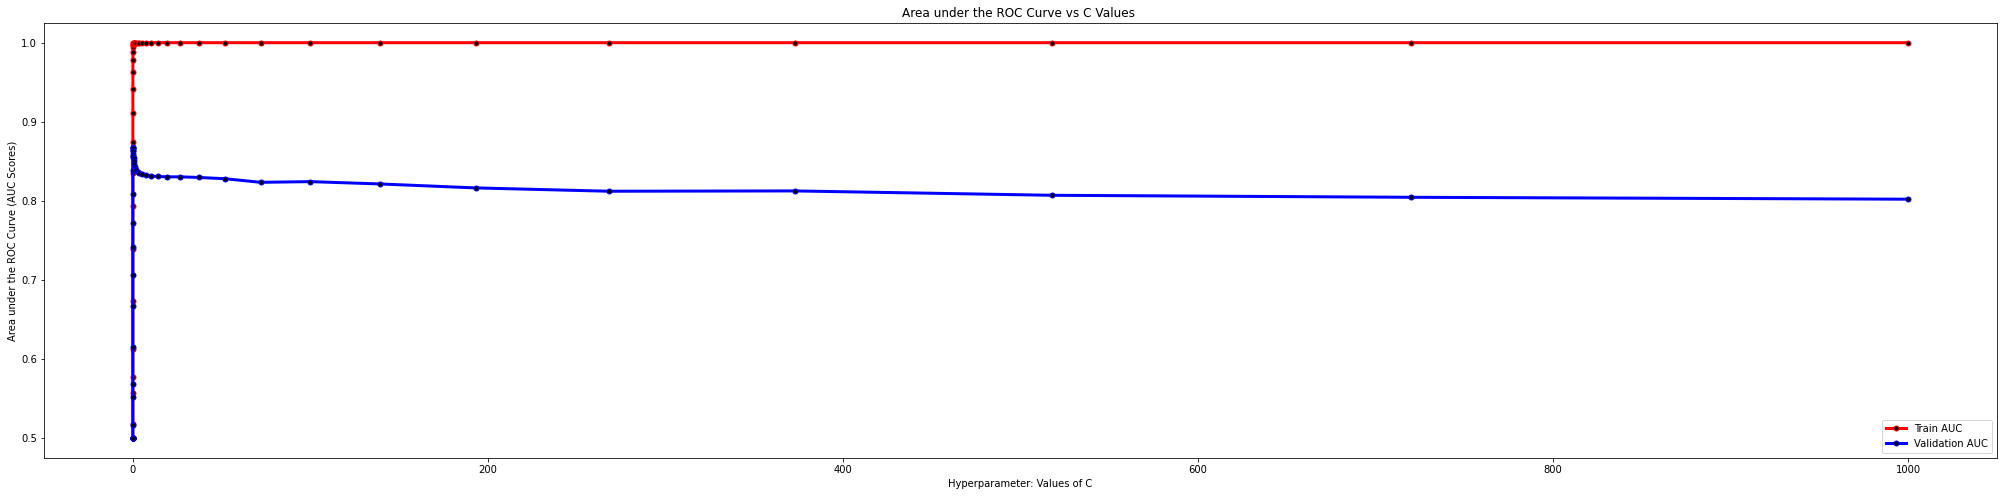

Time taken to complete grid search:  0:00:13.891277

'''PERFORMANCE EVALUATION for Bag-of-Words model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 3000 data points on unseen data for l1 regularization is 2719
Accuracy of the Bag-of-Words model using l1 regularization on unseen data is 90.63333333333333 %
Precision of the Bag-of-Words model using l1 regularization on unseen data is 0.9499
Recall of the Bag-of-Words model using l1 regularization on unseen data is 0.9415
F1 score of the Bag-of-Words model using l1 regularization on unseen data is 0.9457
AUC of the Bag-of-Words model using l1 regularization on unseen data is 0.9189

Clasification report 
              precision    recall  f1-score   support

           0       0.64      0.68      0.66       403
           1       0.95      0.94      0.95      2597

    accuracy                           0.91      3000
   macro avg       0.80      0.81 

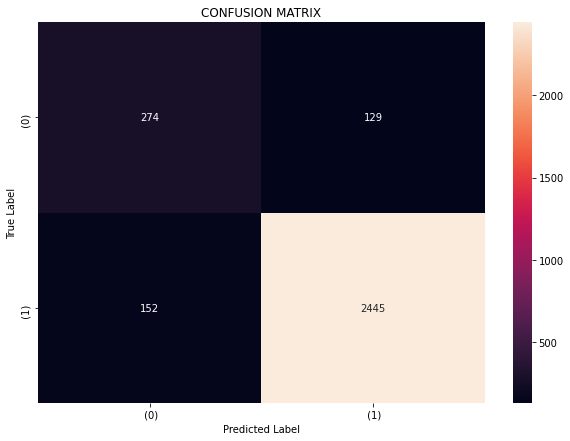

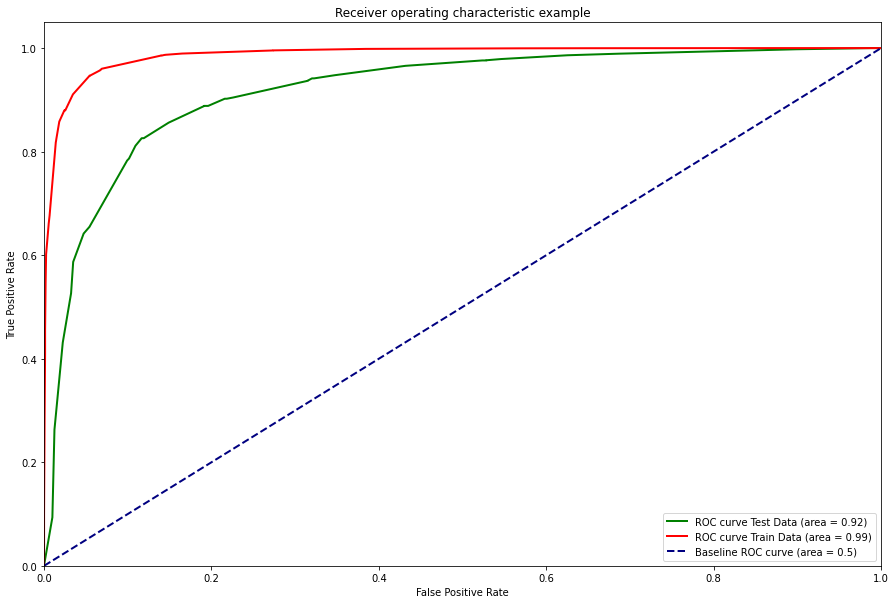

In [18]:
#Load the BOW Vectors we had created earlier and standardize them. We will standardize the train and test data seperately in order to prevent data leakage.
import pickle
from datetime import datetime as dt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

with open('X_train_BOW.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_BOW.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_BOW.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_BOW.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_BOW.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_BOW.pkl', 'rb') as file:
    y_calib = pickle.load(file)   

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, False)
X_test=standardize(X_test, False)
X_calib=standardize(X_calib, False)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
#trained_classifier_BOW_L1 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', 'Bag-of-Words')
trained_classifier_BOW_L1 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', 'Bag-of-Words', solver="liblinear")

#### Calculating sparsity on weight vector obtained using L1 regularization on BOW.

In [19]:
#Calculating sparsity on weight vector obtained using L1 regularization on BOW
#We can also show the using L2 regularization, none of the weight vector becomes zero.
def report_errors(X_train, y_train, X_test, y_test, vectorizationType, regularization, solver="lbfgs"):
    '''Shows the impact of sparsity on increasing the lambda value. (lambda = 1/C). The plot obtained will have the values 
    of lamda on the X axis in increasing order, and the value of the number of non zero elements for each lamda on the Y axis.'''
    
    print("\nError report for the {} model using {} regularization with various values of Lambda".format(vectorizationType, regularization))
    C = np.logspace(3, -4, 1000) #lambda = (1/C). As C decreses it means lambda increases
    non_zeroes_list = []
    lambda_list = []
    count = 0
    for c_value in C:
        classifier = LogisticRegression(C = c_value, penalty = regularization, random_state = 0, solver=solver)
        classifier.fit(X_train, y_train);
        y_pred = classifier.predict(X_test) #Predict the labels for the test set.
        error = 1 - metrics.accuracy_score(y_test, y_pred, normalize=True)
        #error = metrics.mean_absolute_error(y_test, y_pred)
        
        w = classifier.coef_ #w is a weight vector perpendicular to the optimal hyperplane
        non_zeroes = np.count_nonzero(w) #Count the number of non zero elements in the w vector.
        if(count%20 == 0):
            print("Lambda = {}, Error = {}, Non Zero elements = {}".format('{0:.4f}'.format(1/c_value), np.round(error,4), non_zeroes))
        non_zeroes_list.append(non_zeroes)
        lambda_list.append(1/c_value)
        count += 1
    
    #Plot the effect of increasing lamda on the number of non zero elements in the final vector.
    plt.figure(figsize=(10, 10))
    plt.plot(lambda_list, non_zeroes_list, color='green', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='red', markersize=10)
    plt.title('Plot to show the effect of increasing lambda on the sparsity of the LR vector')
    plt.xlabel('Values of Lambda (in increasing order)')
    plt.ylabel('Number of Non Zero elements for a given value of Lambda.')
    plt.show()


Error report for the Bag-of-Words-Model model using l1 regularization with various values of Lambda
Lambda = 0.0010, Error = 0.15, Non Zero elements = 2728
Lambda = 0.0014, Error = 0.148, Non Zero elements = 2694
Lambda = 0.0019, Error = 0.1497, Non Zero elements = 2705
Lambda = 0.0026, Error = 0.1497, Non Zero elements = 2657
Lambda = 0.0036, Error = 0.1463, Non Zero elements = 2620
Lambda = 0.0050, Error = 0.146, Non Zero elements = 2574
Lambda = 0.0069, Error = 0.1427, Non Zero elements = 2518
Lambda = 0.0096, Error = 0.1427, Non Zero elements = 2430
Lambda = 0.0132, Error = 0.14, Non Zero elements = 2367
Lambda = 0.0182, Error = 0.1343, Non Zero elements = 2183
Lambda = 0.0252, Error = 0.1393, Non Zero elements = 2270
Lambda = 0.0348, Error = 0.137, Non Zero elements = 2233
Lambda = 0.0480, Error = 0.1323, Non Zero elements = 2184
Lambda = 0.0663, Error = 0.131, Non Zero elements = 2165
Lambda = 0.0916, Error = 0.1323, Non Zero elements = 2147
Lambda = 0.1265, Error = 0.1307, Non 

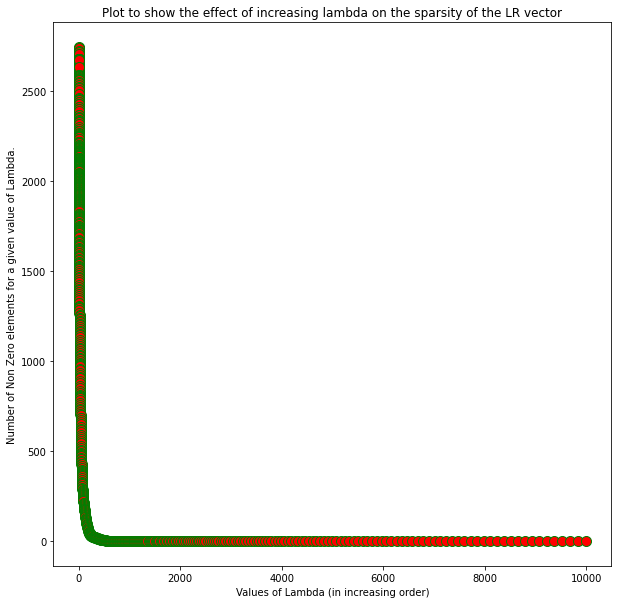

Checking the number of features which has been zeroed out on applying L1 reg.

Total number of features present in the BOW representation originally:  2814
Total number of features which became zero on applying L1 reg:  1566


In [20]:
#Calculating sparsity on weight vector obtained using L1 regularization on BOW. The function also shows the effect on sparsity with the decrease in the value of the hyper paparemetr C. 
report_errors(X_train, y_train, X_test , y_test, 'Bag-of-Words-Model', 'l1', solver="liblinear")

#Find the number of features which has been zeroed out on applying L1 reg.
print("Checking the number of features which has been zeroed out on applying L1 reg.")
weight_vector = trained_classifier_BOW_L1.coef_ #Get the final weight vector with the best value of Hyperparameters
non_zeroes = np.count_nonzero(weight_vector)
zeroes = X_train.shape[1]-non_zeroes #Total number of features whose value has become 0 after applying L1 regularization.

print("\nTotal number of features present in the BOW representation originally: ",X_train.shape[1])
print("Total number of features which became zero on applying L1 reg: ",zeroes)

In [21]:
#Calculate sparsity.
sparsity = (zeroes/X_train.shape[1]) * 100
print("Sparsity : {}%".format(sparsity))

Sparsity : 55.65031982942431%


<b>Conclusion:</b><br>
We can clearly see above that as the values of lambda increases (i.e. C decreases), the number of non zero elements present in the weight vector also decreases. In other words as C decreases, the sparsity of the weight vector increases.

#### Applying Logistic Regression with L2 regularization on BOW



USING L2 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS FOR Bag-of-Words MODEL. 
*******************************************************************************************************
Best estimator for l2 regularization : 
 LogisticRegression(C=0.0003727593720314938, random_state=0)
Best Score for l2 regularization :  0.869853567793623
The optimal value of C using l1 regularization is : 0.0003727593720314938


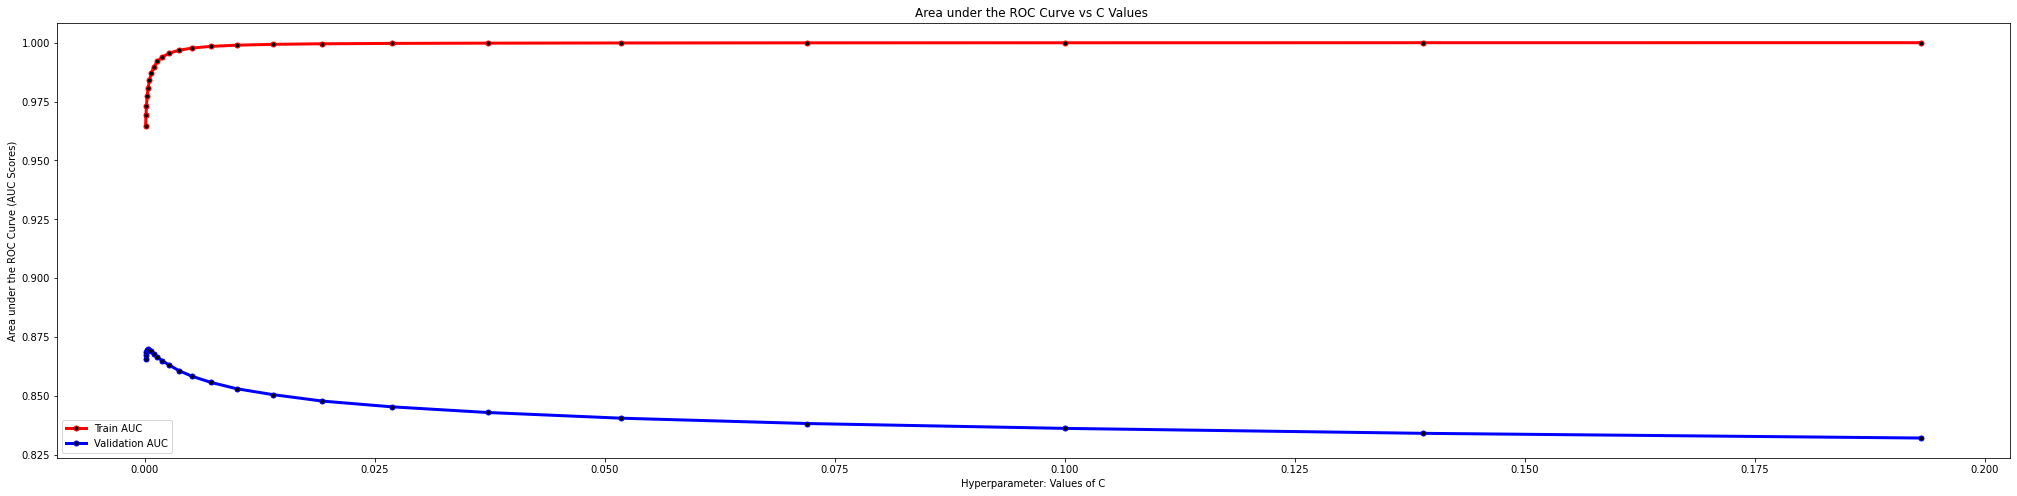

Time taken to complete grid search:  0:00:26.215241

'''PERFORMANCE EVALUATION for Bag-of-Words model using l2 regularization'''

Detailed report for Logistic regression using l2 regulaization

The number of accurate predictions out of 3000 data points on unseen data for l2 regularization is 2733
Accuracy of the Bag-of-Words model using l2 regularization on unseen data is 91.10000000000001 %
Precision of the Bag-of-Words model using l2 regularization on unseen data is 0.947
Recall of the Bag-of-Words model using l2 regularization on unseen data is 0.9503
F1 score of the Bag-of-Words model using l2 regularization on unseen data is 0.9487
AUC of the Bag-of-Words model using l2 regularization on unseen data is 0.9257

Clasification report 
              precision    recall  f1-score   support

           0       0.67      0.66      0.66       403
           1       0.95      0.95      0.95      2597

    accuracy                           0.91      3000
   macro avg       0.81      0.80  

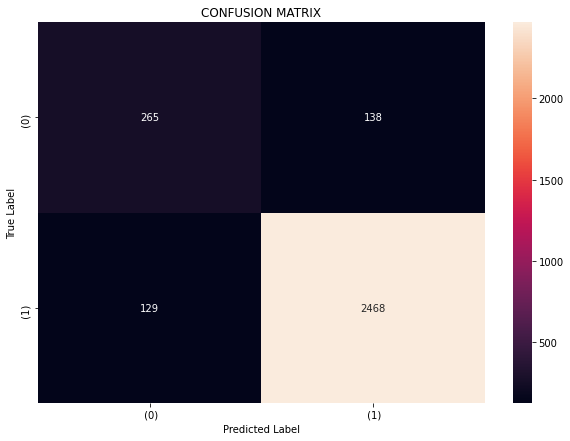

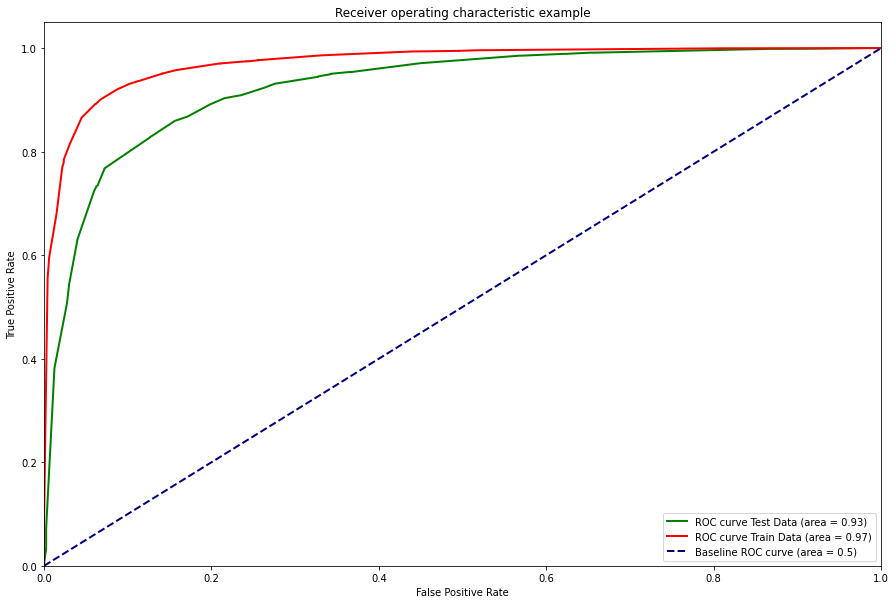

In [22]:
trained_classifier_BOW_L2 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', 'Bag-of-Words', "lbfgs")

#### Applying Logistic Regression with L2 regularization on BOW


USING L2 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS FOR Bag-of-Words MODEL. 
*******************************************************************************************************
Best estimator for l2 regularization : 
 LogisticRegression(C=0.01, random_state=0, solver='liblinear')
Best Score for l2 regularization :  0.8376629275228048
The optimal value of C using l1 regularization is : 0.01


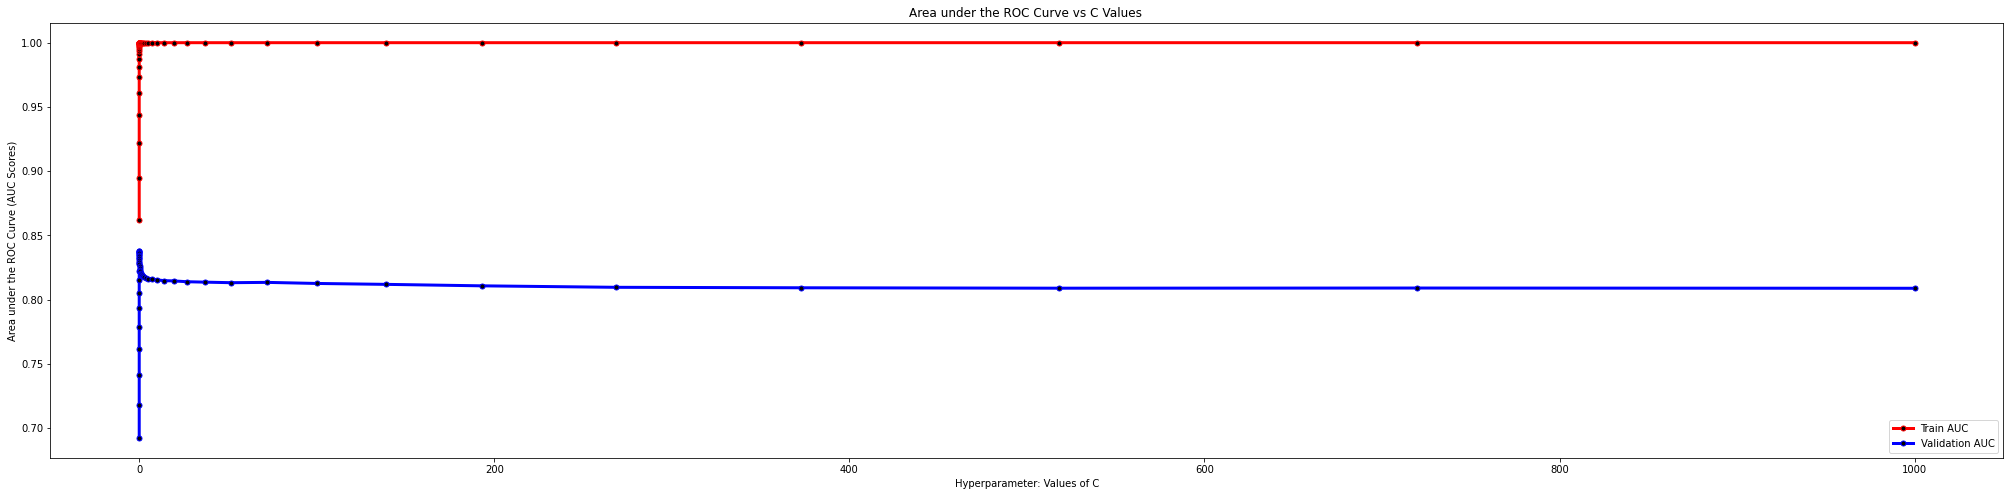

Time taken to complete grid search:  0:00:17.709870

'''PERFORMANCE EVALUATION for Bag-of-Words model using l2 regularization'''

Detailed report for Logistic regression using l2 regulaization

The number of accurate predictions out of 3000 data points on unseen data for l2 regularization is 2712
Accuracy of the Bag-of-Words model using l2 regularization on unseen data is 90.4 %
Precision of the Bag-of-Words model using l2 regularization on unseen data is 0.9483
Recall of the Bag-of-Words model using l2 regularization on unseen data is 0.9403
F1 score of the Bag-of-Words model using l2 regularization on unseen data is 0.9443
AUC of the Bag-of-Words model using l2 regularization on unseen data is 0.907

Clasification report 
              precision    recall  f1-score   support

           0       0.64      0.67      0.65       403
           1       0.95      0.94      0.94      2597

    accuracy                           0.90      3000
   macro avg       0.79      0.81      0.80     

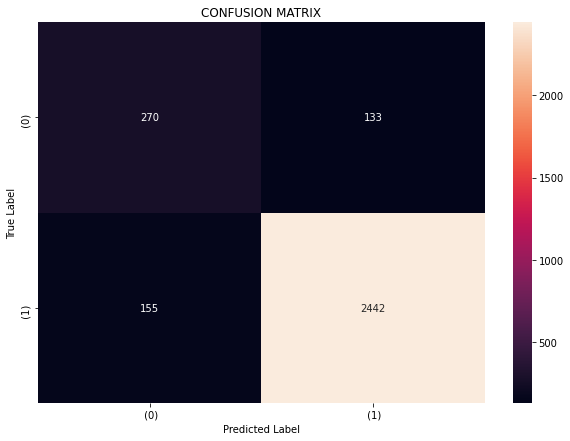

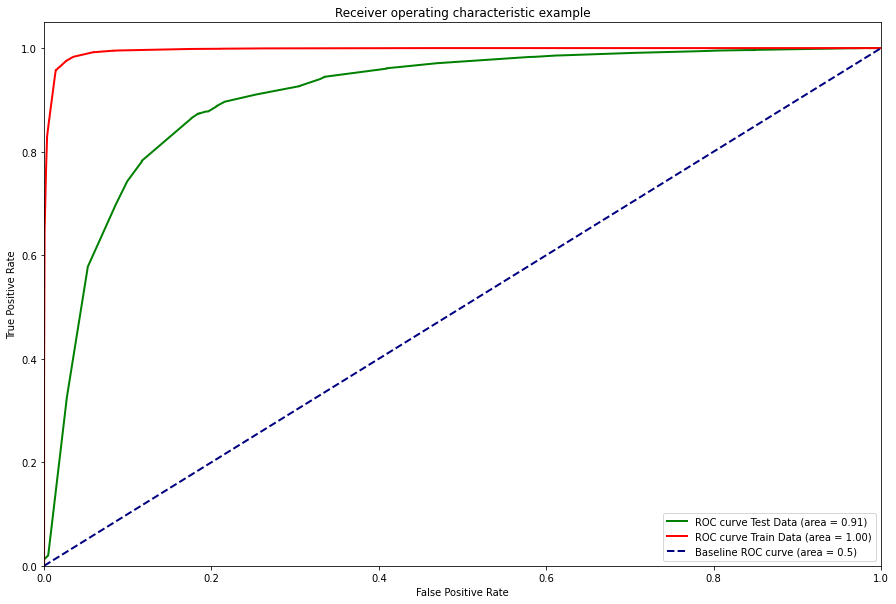

In [23]:
trained_classifier_BOW_L2 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', 'Bag-of-Words', solver="liblinear")

#### Performing pertubation test (multicollinearity check) on BOW

In [24]:

def check_multicollinearity(X, y, trained_classifier, vectorizer_object):
    '''Pertubation Test
    1. Get the weights W after you fit your model with the data X i.e Train data.
    2. Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)      
    3. Fit the model again on data X' and get the weights W'
    4. Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
    5. Now find the % change between W and W' (| (W-W') / (W) |)*100)
    6. Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector
    7. Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th 
       percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5
    8. Print the feature names whose % change is more than a threshold x(in our example it's 2.5)'''

    model_denoise = trained_classifier
    model_denoise.fit(X,y)

    #Get the weight vector after fitting the model with the best estimator obtained from grid search cv.
    previous_weight_vector = (model_denoise.coef_).ravel() # W in statement 1

    #Add a small noise to the data
    noise = np.random.normal(loc=0.0, scale=0.000001)

    #Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)
    X.data = X.data + noise

    #Fit the model again on data X' and get the weights W'
    model_noisy = trained_classifier
    model_noisy.fit(X, y_train)
    noisy_weight_vector = (model_noisy.coef_).ravel() # W' in statement 3

    #Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
    eps = 1e-6
    previous_weight_vector = previous_weight_vector + eps   #W = W+10^-6
    noisy_weight_vector = noisy_weight_vector + eps         #W’= W’+10^-6

    #Calculate % change between W and W' [|(W-W')/W|)*100]
    change = (previous_weight_vector-noisy_weight_vector)
    percntg_change = list(abs( (change/previous_weight_vector) * 100 ))
    backup = percntg_change.copy()
    percntg_change.sort()
    #percntg_change.reverse()

    #Plot the elbow plot 
    plt.figure(figsize=(35,8))
    plt.plot(np.arange(0,len(percntg_change)) , percntg_change, color='red', linestyle='-', linewidth=2, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
    plt.title('Percentage change in weights. ')
    plt.xlabel('Index of features in the sorted list.')
    plt.ylabel('Percentage change in weights corresponding to the features.')
    plt.legend()
    plt.show()

    #Plot the 10th, 20th, 30th .... 100th Percentiles.
    percentiles = [i for i in np.arange(0.0,101.0,1.0)]
    percentile_val = [np.percentile(percntg_change, i) for i in percentiles] 
    plt.figure(figsize=(35,8))
    plt.plot(np.arange(0.0,101.0,1.0) , percentile_val, color='red', linestyle='-', linewidth=2, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
    plt.title('Percentage change in weights. ')
    plt.xlabel('Percentiles')
    plt.ylabel('Percentage change in weights corresponding to the features.')
    plt.legend()
    plt.show()

    print("NOTE: From the above plot we can see that there is a sudden change in the values of the weight vector around the 99th percentile mark. We will now draw a plot which \
    shows us the change in the values of the weight vector in the 90th to 100th percentile range.")

    #Plot the 90th, 91st, 92nd .... 100th Percentiles.
    percentiles = [i for i in np.arange(90.0,101.0,1.0)]
    percentile_val = [np.percentile(percntg_change, i) for i in percentiles] 
    plt.figure(figsize=(35,8))
    plt.plot(np.arange(90.0,101.0,1.0) , percentile_val, color='red', linestyle='-', linewidth=2, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
    plt.title('Percentage change in weights. ')
    plt.xlabel('Percentiles')
    plt.ylabel('Percentage change in weights corresponding to the features.')
    plt.legend()
    plt.show()

    print("NOTE: From the above plot we can see that there is a sudden change in the values of the weight vector from 99th to 100th percentile. We will now draw a plot which \
    shows us the change in the values of the weight vector in the 99th to 100th percentile range.")

    #Plot the 99.1th,99.2th,99.3th .... 100th Percentiles.
    percentiles = [i for i in np.arange(99.0,100.1,0.1)]
    percentile_val = [np.percentile(percntg_change, i) for i in percentiles] 
    plt.figure(figsize=(35,8))
    plt.plot(np.arange(99.0,100.1,0.1) , percentile_val, color='red', linestyle='-', linewidth=2, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
    plt.title('Percentage change in weights. ')
    plt.xlabel('Percentiles')
    plt.ylabel('Percentage change in weights corresponding to the features.')
    plt.legend()
    plt.show()

    print("NOTE: Now we can clearly see from the above plot that the change in percentage weights values is almost steady till 99.8 percentile, \
    beyond which there is a very sudden increase in the values of the percentage change in the weights. So we will take our threshold to be 99.8 percentile \
    and find those features for which there is a sudden change in the weights values. Let's proceed with that.")

    #Get the value corresponding to 99.8th percentile. Use this value to obtain all the values in percentage change vector which is greater than threshold.
    threshold = np.percentile(percntg_change, 99.8)
    mlticlinr_featurs=[]
    for i in backup:
        if(i>threshold):
            mlticlinr_featurs.append(i)

    #Get the feature index for all the features which are multicolinear.
    feature_index = []
    for i in range(0,len(mlticlinr_featurs)):
        ind = backup.index(mlticlinr_featurs[i])
        feature_index.append(ind)

    #Contains all the features that are there in the BOW Vectorizer.
    feat_names = vectorizer_object.get_feature_names()

    #Get the feature names which are multicolinear.
    mul_feat = []
    for index in feature_index:
        mul_feat.append(feat_names[index])

    #Print the multicollinear features.
    print("\n\nThe features which are multicolinear are printed below: ")
    print(mul_feat)
    return percntg_change

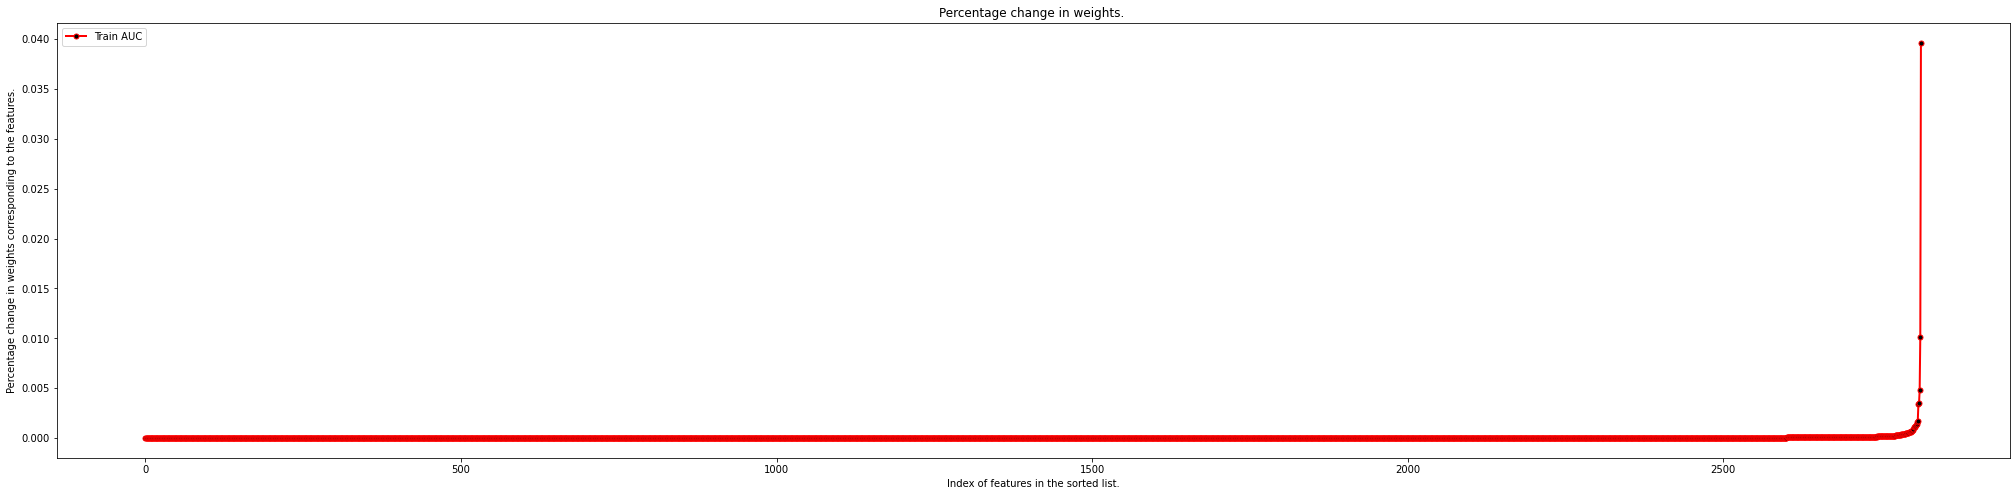

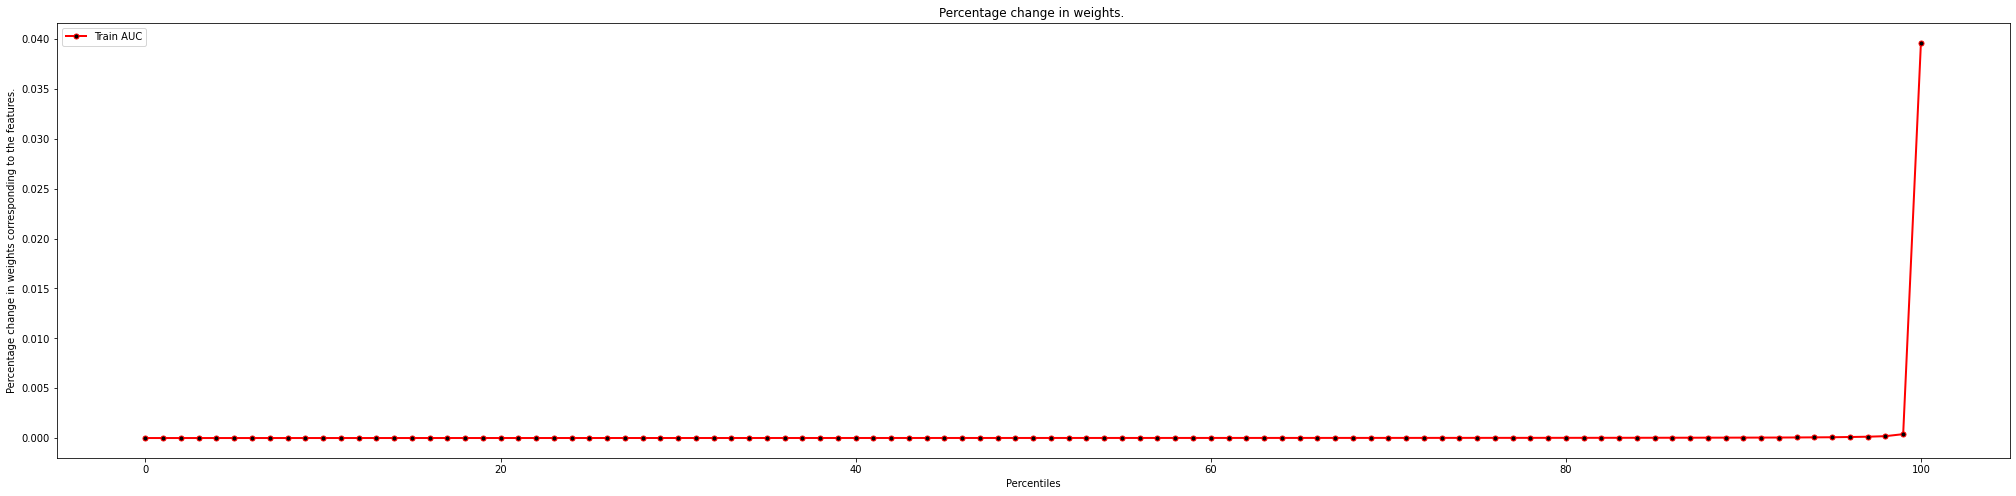

NOTE: From the above plot we can see that there is a sudden change in the values of the weight vector around the 99th percentile mark. We will now draw a plot which     shows us the change in the values of the weight vector in the 90th to 100th percentile range.


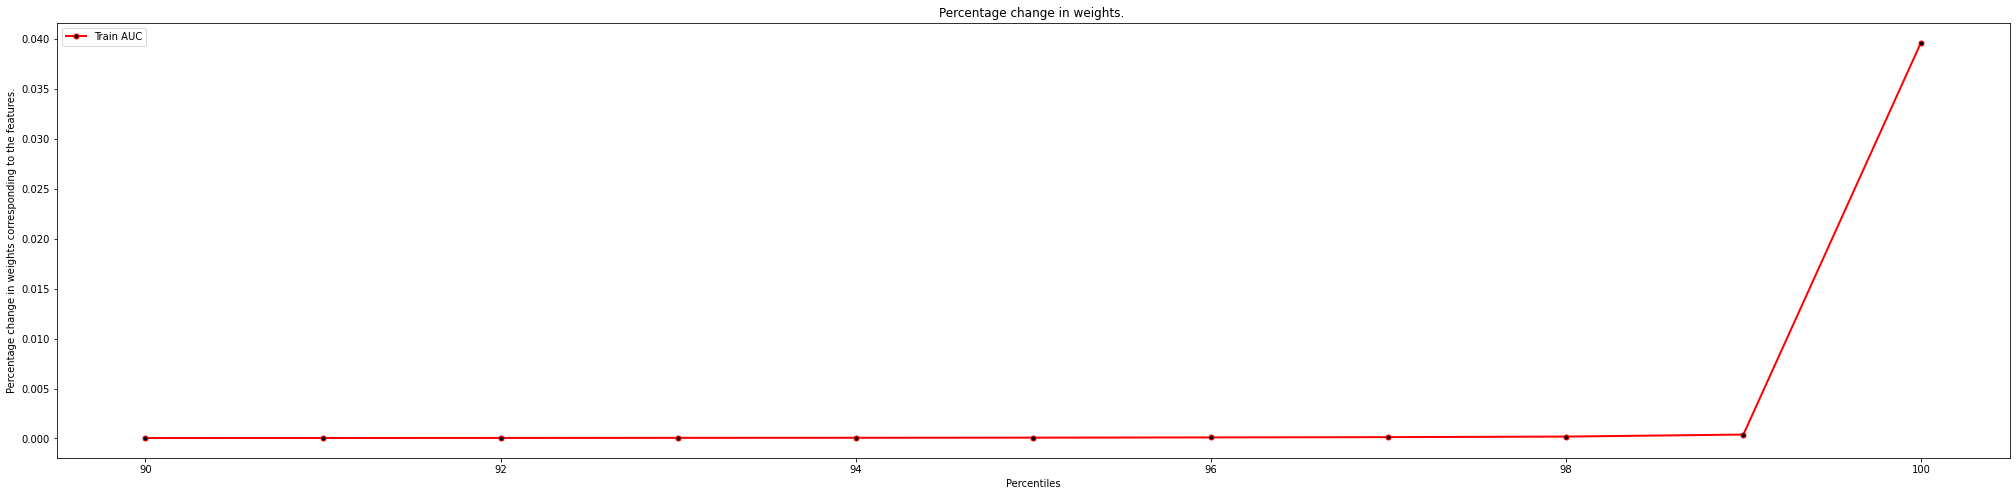

NOTE: From the above plot we can see that there is a sudden change in the values of the weight vector from 99th to 100th percentile. We will now draw a plot which     shows us the change in the values of the weight vector in the 99th to 100th percentile range.


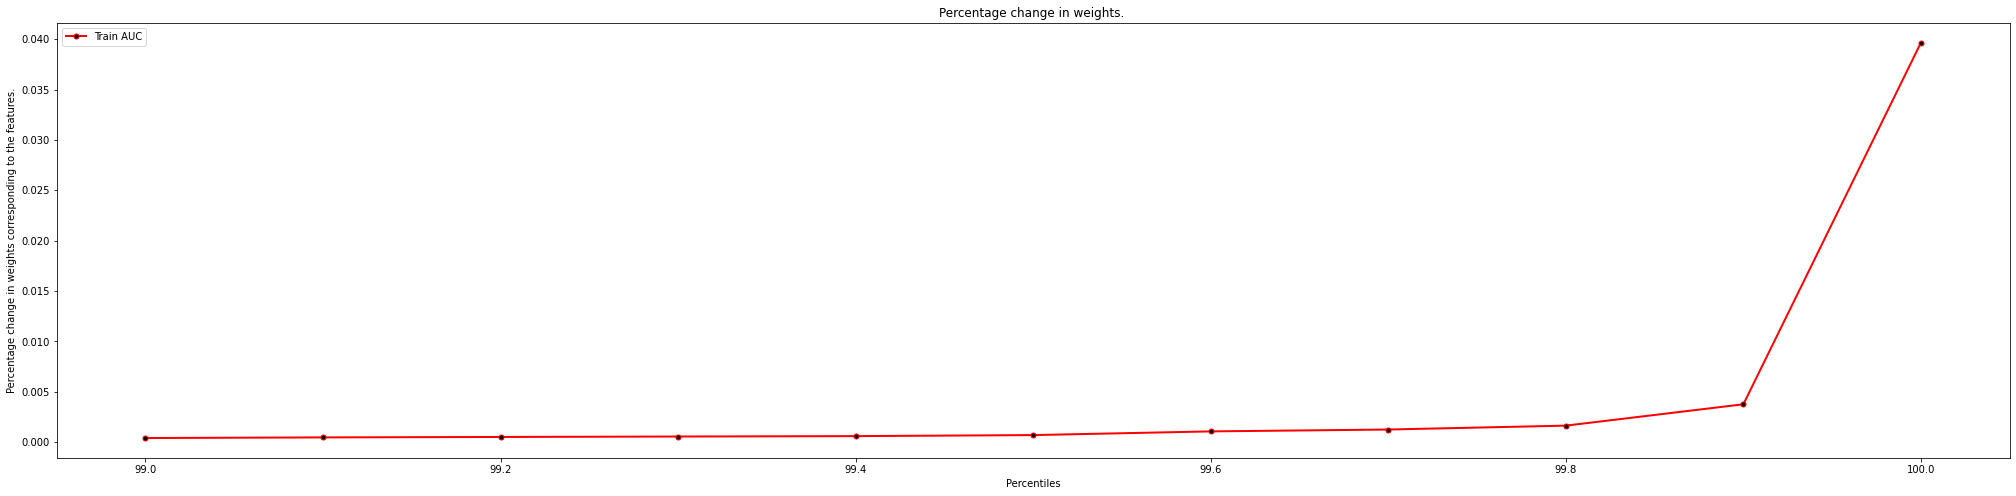

NOTE: Now we can clearly see from the above plot that the change in percentage weights values is almost steady till 99.8 percentile,     beyond which there is a very sudden increase in the values of the percentage change in the weights. So we will take our threshold to be 99.8 percentile     and find those features for which there is a sudden change in the weights values. Let's proceed with that.


The features which are multicolinear are printed below: 
['attempt', 'bull', 'chip like', 'free syrup', 'fur', 'greeni']


In [25]:
#The below function is used to perform the pertubation test and check if the features are multicollinear. Also state the features which are multicollinear.
percntg_change=check_multicollinearity(X_train, y_train, trained_classifier_BOW_L2, cv_object)

#### Feature Importance on BOW
##### Top 10 important features of positive class from

In [37]:
#Print the top 100 positive features using L1 regularization.
top_pos_features = (-trained_classifier_BOW_L1.coef_[0, :]).argsort()  
top_pos_features = np.take(cv_object.get_feature_names(), top_pos_features[:100])

print("The top 100 positive features using L1 regularization...\n")
print(top_pos_features)

#Print the top 100 positive features using L2 regularization.
top_pos_features = (-trained_classifier_BOW_L2.coef_[0, :]).argsort()  
top_pos_features = np.take(cv_object.get_feature_names(), top_pos_features[:100])

print("\nThe top 100 positive features using L2 regularization...\n")
print(top_pos_features)

The top 100 positive features using L1 regularization...

['dog still' 'content' 'brown sugar' 'anxieti' 'complain' 'chip love'
 'enthusiast' 'famili eat' 'green bean' 'cheat' 'bag shake' 'coast'
 'flavor say' 'desert' 'jalapeno' 'guest' 'carb diet' 'inch thick'
 'best gluten' 'good give' 'caution' 'chill' 'brother' 'acid' 'attach'
 'flat' 'fourth' 'cup' 'insid' 'australian' 'good good' 'get someth'
 'box not' 'credit' 'adult' 'choke' 'hard' 'food never' 'goe crazi'
 'coffe drinker' 'greyhound' 'absolut favorit' 'formula chang'
 'could order' 'finest' 'fat chip' 'alway get' 'grill' 'flavor howev'
 'amber' 'browni mix' 'aw' 'hot milk' 'hostess' 'distinct' 'cant' 'bob'
 'cousin' 'hard get' 'durabl' 'cream onion' 'coffe first' 'ach' 'anim'
 'inner' 'buy groceri' 'involv' 'alway tast' 'everi two' 'far favorit'
 'happybabi' 'dog happi' 'fajita' 'fill' 'dog like' 'hyper' 'destroy'
 'date' 'eater' 'dog absolut' 'bad batch' 'carbohydr' 'counter'
 'even littl' 'bitter aftertast' 'fine ground' '

##### Top 10 important features of negative class from

In [38]:
#Print the top 100 negative features using L1 regularization.
top_neg_features = (trained_classifier_BOW_L1.coef_[0, :]).argsort()  
top_neg_features = np.take(cv_object.get_feature_names(), top_neg_features[:100])

print("The top 100 positive features using L1 regularization...\n")
print(top_neg_features)

#Print the top 100 negative features using L2 regularization.
top_neg_features = (trained_classifier_BOW_L2.coef_[0, :]).argsort()  
top_neg_features = np.take(cv_object.get_feature_names(), top_neg_features[:100])

print("\nThe top 100 positive features using L2 regularization...\n")
print(top_neg_features)

The top 100 positive features using L1 regularization...

['espresso machin' 'buy food' 'intact' 'ground beef' 'intend' 'greatest'
 'half hour' 'alway' 'eat way' 'alway seem' 'everi time' 'cherri'
 'cut calori' 'cup brewer' 'beer' 'good though' 'border colli'
 'flavor want' 'ignor' 'buy onlin' 'decor' 'circl' 'fri' 'appear'
 'good size' 'food item' 'fat low' 'drink regular' 'complet' 'alway keep'
 'favourit' 'hike' 'furri' 'dog get' 'add water' 'alway fresh'
 'coffe keurig' 'breast' 'food one' 'calcium' 'butter mix' 'hope get'
 'buffalo' 'find amazon' 'establish' 'delici also' 'hang' 'good food'
 'great deal' 'husband love' 'drink black' 'ice cream' 'chocol chip'
 'anyon els' 'bit like' 'coffe time' 'chew' 'best mix' 'best' 'bergamot'
 'citrus' 'breath smell' 'flavor well' 'flavor excel' 'goodi' 'grand'
 'foam' 'cool' 'intoler' 'distribut' 'dri kibbl' 'first thought'
 'fat cholesterol' 'eat love' 'everi' 'cup brew' 'get one' 'dip' 'art'
 'find groceri' 'heartburn' 'amazon free' 'holida

### Logistic Regression on TFIDF
#### Applying Logistic Regression with L1 regularization on TFIDF,

Shape of the train data matrix:  (10000, 6411)
Shape of the test data matrix:  (3000, 6411)
Shape of the calibration data matrix:  (4000, 6411)

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS FOR TF-IDF MODEL. 
*******************************************************************************************************
Best estimator for l1 regularization : 
 LogisticRegression(C=0.03727593720314938, penalty='l1', random_state=0,
                   solver='liblinear')
Best Score for l1 regularization :  0.8852237383658496
The optimal value of C using l1 regularization is : 0.03727593720314938


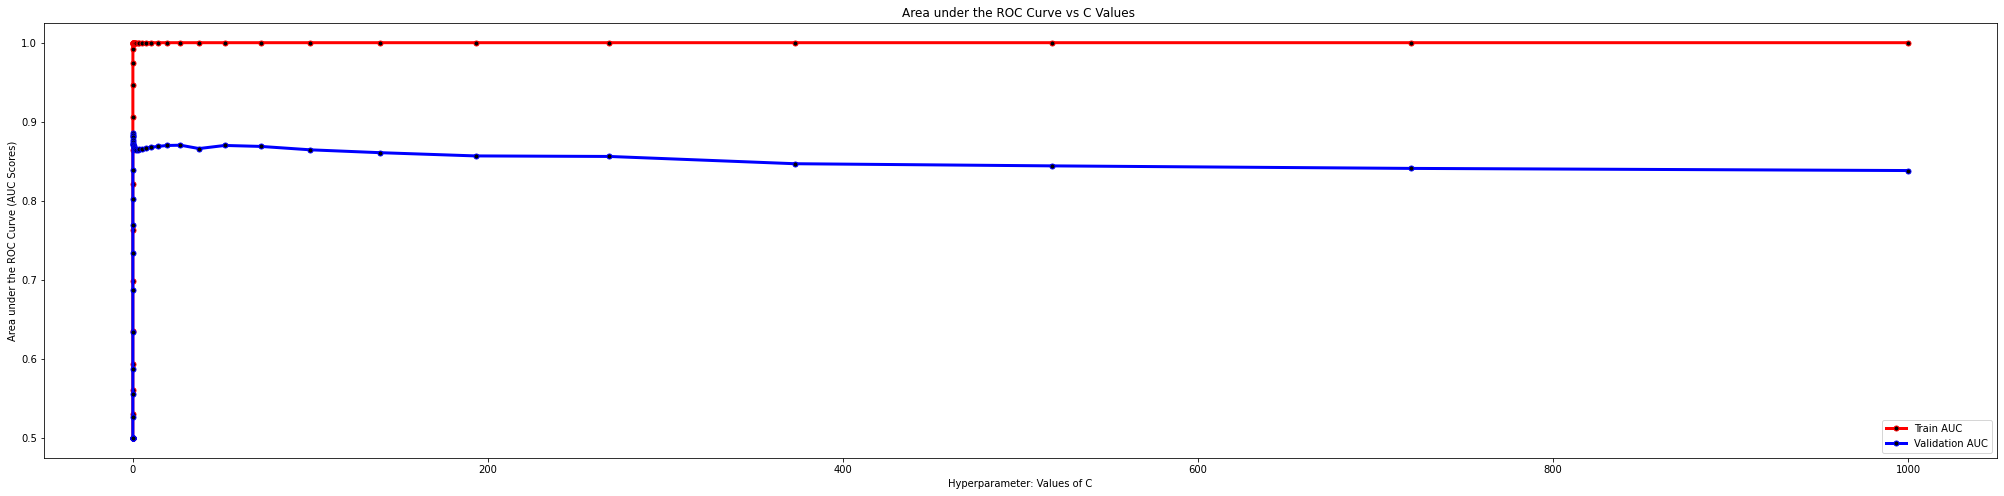

Time taken to complete grid search:  0:00:14.075553

'''PERFORMANCE EVALUATION for TF-IDF model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 3000 data points on unseen data for l1 regularization is 2745
Accuracy of the TF-IDF model using l1 regularization on unseen data is 91.5 %
Precision of the TF-IDF model using l1 regularization on unseen data is 0.9578
Recall of the TF-IDF model using l1 regularization on unseen data is 0.9434
F1 score of the TF-IDF model using l1 regularization on unseen data is 0.9505
AUC of the TF-IDF model using l1 regularization on unseen data is 0.9405

Clasification report 
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       403
           1       0.96      0.94      0.95      2597

    accuracy                           0.92      3000
   macro avg       0.81      0.84      0.82      3000
weighted avg       0.92      

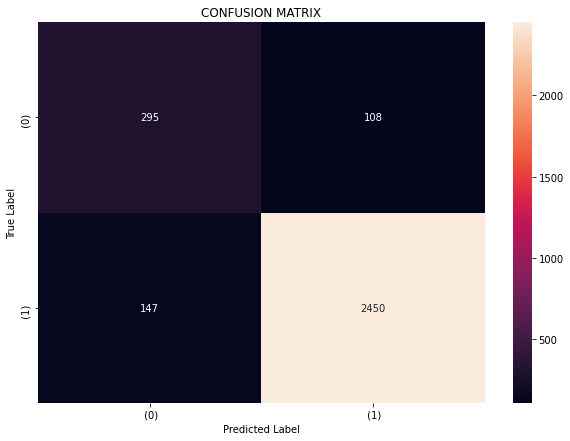

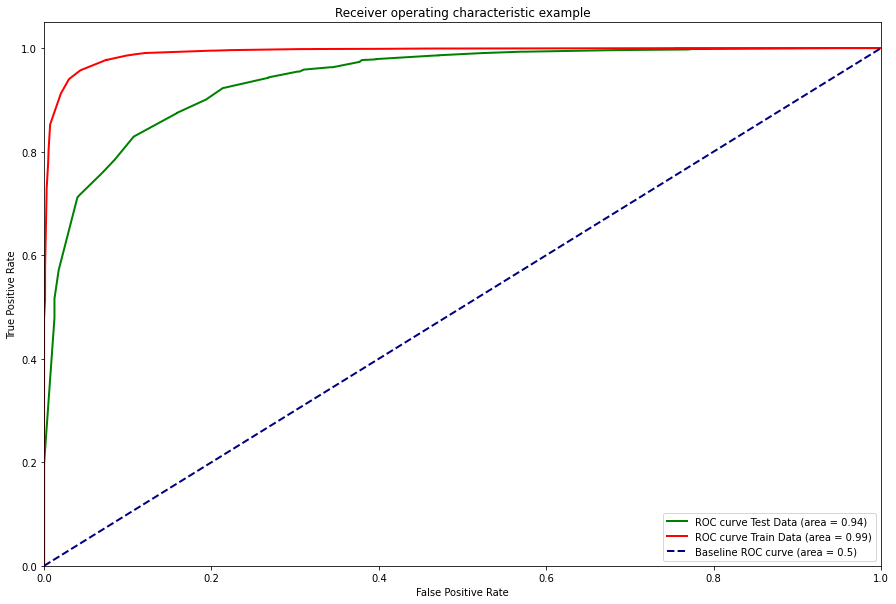

In [33]:
#Load the TF-IDF Vectors we had created earlier and standardize them. We will standardize the traina and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_TFIDF.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_TFIDF.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_TFIDF.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_TFIDF.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_TFIDF.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_TFIDF.pkl', 'rb') as file:
    y_calib = pickle.load(file)    

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, False)
X_test=standardize(X_test, False)
X_calib=standardize(X_calib, False)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_TFIDF_L1 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', 'TF-IDF', solver="liblinear")

#### Applying Logistic Regression with L2 regularization on TFIDF,


USING L2 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS FOR TF-IDF MODEL. 
*******************************************************************************************************
Best estimator for l2 regularization : 
 LogisticRegression(C=0.00019306977288832496, random_state=0)
Best Score for l2 regularization :  0.8940710132217268
The optimal value of C using l1 regularization is : 0.00019306977288832496


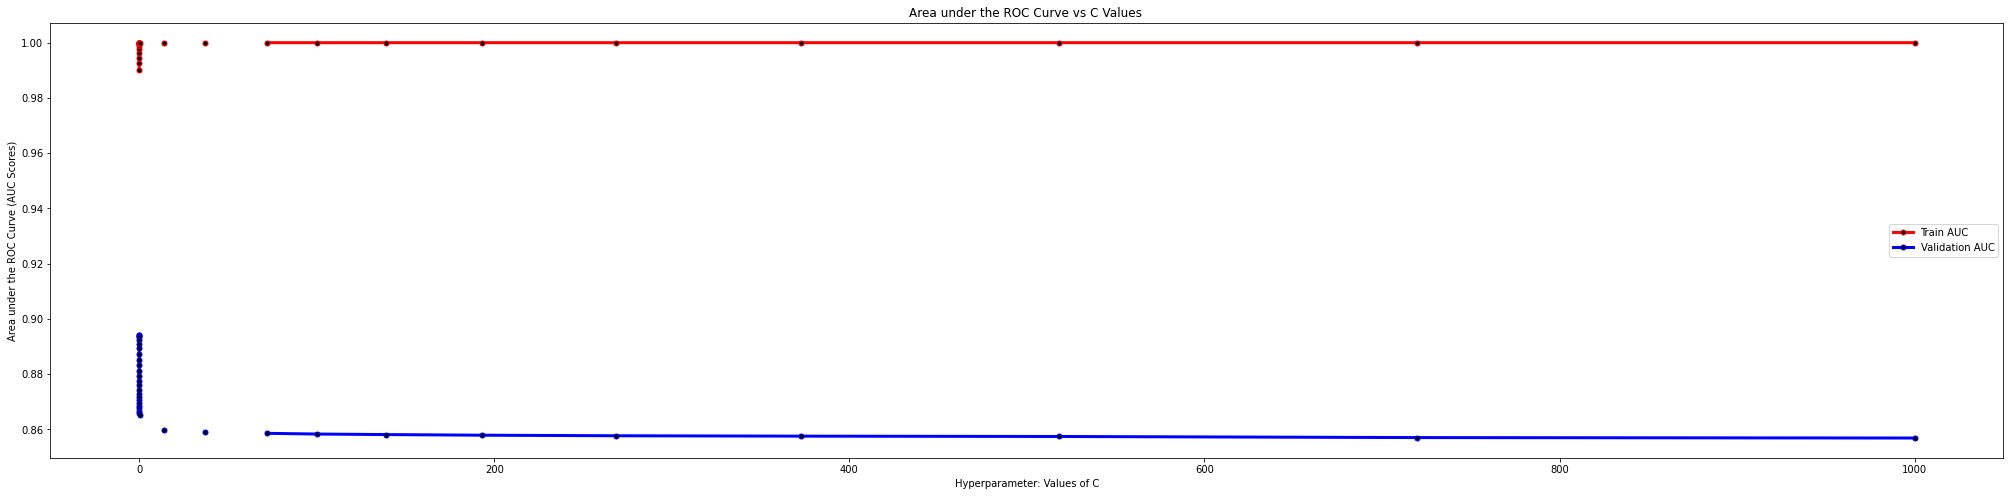

Time taken to complete grid search:  0:00:31.197122

'''PERFORMANCE EVALUATION for TF-IDF model using l2 regularization'''

Detailed report for Logistic regression using l2 regulaization

The number of accurate predictions out of 3000 data points on unseen data for l2 regularization is 2759
Accuracy of the TF-IDF model using l2 regularization on unseen data is 91.96666666666667 %
Precision of the TF-IDF model using l2 regularization on unseen data is 0.9399
Recall of the TF-IDF model using l2 regularization on unseen data is 0.9692
F1 score of the TF-IDF model using l2 regularization on unseen data is 0.9543
AUC of the TF-IDF model using l2 regularization on unseen data is 0.9326

Clasification report 
              precision    recall  f1-score   support

           0       0.75      0.60      0.67       403
           1       0.94      0.97      0.95      2597

    accuracy                           0.92      3000
   macro avg       0.85      0.78      0.81      3000
weighted avg    

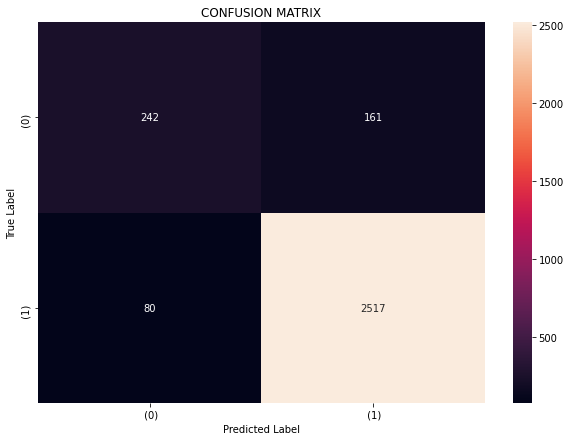

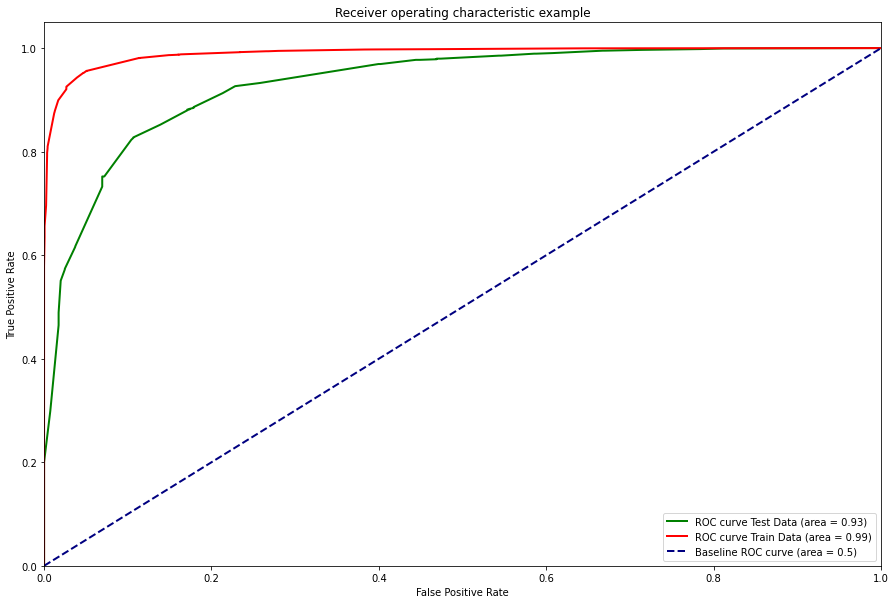

In [34]:
#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_TFIDF_L2 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', 'TF-IDF', solver="lbfgs")

#### Feature Importance on TFIDF
##### Top 100 important features of positive class from

In [39]:
#Print the top 100 positive features using L1 regularization.
top_pos_features = (-trained_classifier_TFIDF_L1.coef_[0, :]).argsort()  
top_pos_features = np.take(tf_idf_obj.get_feature_names(), top_pos_features[:100])

print("The top 100 positive features using L1 regularization...\n")
print(top_pos_features)

#Print the top 100 positive features using L2 regularization.
top_pos_features = (-trained_classifier_TFIDF_L2.coef_[0, :]).argsort()  
top_pos_features = np.take(tf_idf_obj.get_feature_names(), top_pos_features[:100])

print("\nThe top 100 positive features using L2 regularization...\n")
print(top_pos_features)

The top 100 positive features using L1 regularization...

['love' 'great' 'good' 'delici' 'best' 'recommend' 'not disappoint'
 'favorit' 'perfect' 'nice' 'excel' 'thank' 'well' 'happi' 'calori'
 'definit' 'enjoy' 'tasti' 'quick' 'worth' 'not bad' 'breath' 'find'
 'food' 'yummi' 'without' 'amaz' 'easi' 'wonder' 'keep' 'bake' 'store'
 'spici' 'addict' 'alway' 'day' 'stapl' 'deliv' 'free' 'star' 'right'
 'pleasant surpris' 'glad' 'year' 'fantast' 'hook' 'morn' 'satisfi' 'also'
 'high' 'not strong' 'toast' 'smooth' 'bring' 'teeth' 'may not' 'continu'
 'home' 'tast great' 'awesom' 'bit' 'add' 'like much' 'healthier' 'safe'
 'earl' 'fresh' 'varieti' 'littl' 'use' 'crazi' 'need' 'plan' 'glass'
 'favorit toy' 'hesit' 'beat' 'program' 'previous review' 'sometim'
 'not greasi' 'reason' 'venison' 'easier' 'tire' 'time' 'surpris'
 'amazon vine' 'wish' 'rememb' 'help' 'yet' 'kitti' 'make' 'price' 'serv'
 'sweet' 'rawhid' 'high recommend' 'togeth']

The top 100 positive features using L2 regularizat

#### Top 100 important features of negative class from

In [40]:
#Print the top 100 negative features using L1 regularization.
top_neg_features = (trained_classifier_TFIDF_L1.coef_[0, :]).argsort()  
top_neg_features = np.take(tf_idf_obj.get_feature_names(), top_neg_features[:100])

print("The top 100 negative features using L1 regularization....\n")
print(top_neg_features)

#Print the top 100 negative features using L2 regularization.
top_neg_features = (trained_classifier_TFIDF_L2.coef_[0, :]).argsort()  
top_neg_features = np.take(tf_idf_obj.get_feature_names(), top_neg_features[:100])

print("\nThe top 100 negative features using L2 regularization....\n")
print(top_neg_features)

The top 100 negative features using L1 regularization....

['disappoint' 'not recommend' 'not worth' 'bad' 'not purchas' 'not good'
 'worst' 'not even' 'aw' 'weak' 'not' 'terribl' 'plastic' 'happi babi'
 'two star' 'return' 'horribl' 'mayb' 'thought' 'disgust' 'poor' 'refund'
 'not buy' 'wast money' 'could' 'expir' 'flavorless' 'not work' 'stale'
 'unfortun' 'definit not' 'suppos' 'high hope' 'not tast' 'chemic' 'item'
 'dollar' 'bland' 'would great' 'flat' 'descript' 'didnt' 'shame'
 'opposit' 'half price' 'bewar' 'trash' 'yuck' 'not order' 'box'
 'fri bake' 'mat' 'stick' 'gave' 'unpleas' 'would good' 'googl' 'throw'
 'not happi' 'peopl like' 'would rather' 'walmart' 'product not' 'expos'
 'list' 'useless' 'guess' 'stool' 'perhap' 'away' 'not impress'
 'noth like' 'chew rope' 'vomit' 'soggi' 'toy one' 'tast' 'made china'
 'spit' 'smell' 'danger' 'rip' 'idea' 'not help' 'dash' 'rancid' 'destroy'
 'new' 'one would' 'bought' 'broke' 'good peanut' 'plant' 'matter' 'threw'
 'gross' 'would 

### Logistic Regression on AVG W2V
#### Applying Logistic Regression with L1 regularization on AVG W2V

Shape of the train data matrix:  (10000, 200)
Shape of the test data matrix:  (3000, 200)
Shape of the calibration data matrix:  (4000, 200)

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS FOR AVG-WORD-TO-VEC MODEL. 
*******************************************************************************************************
Best estimator for l1 regularization : 
 LogisticRegression(C=0.19306977288832497, penalty='l1', random_state=0,
                   solver='liblinear')
Best Score for l1 regularization :  0.7950854665882303
The optimal value of C using l1 regularization is : 0.19306977288832497


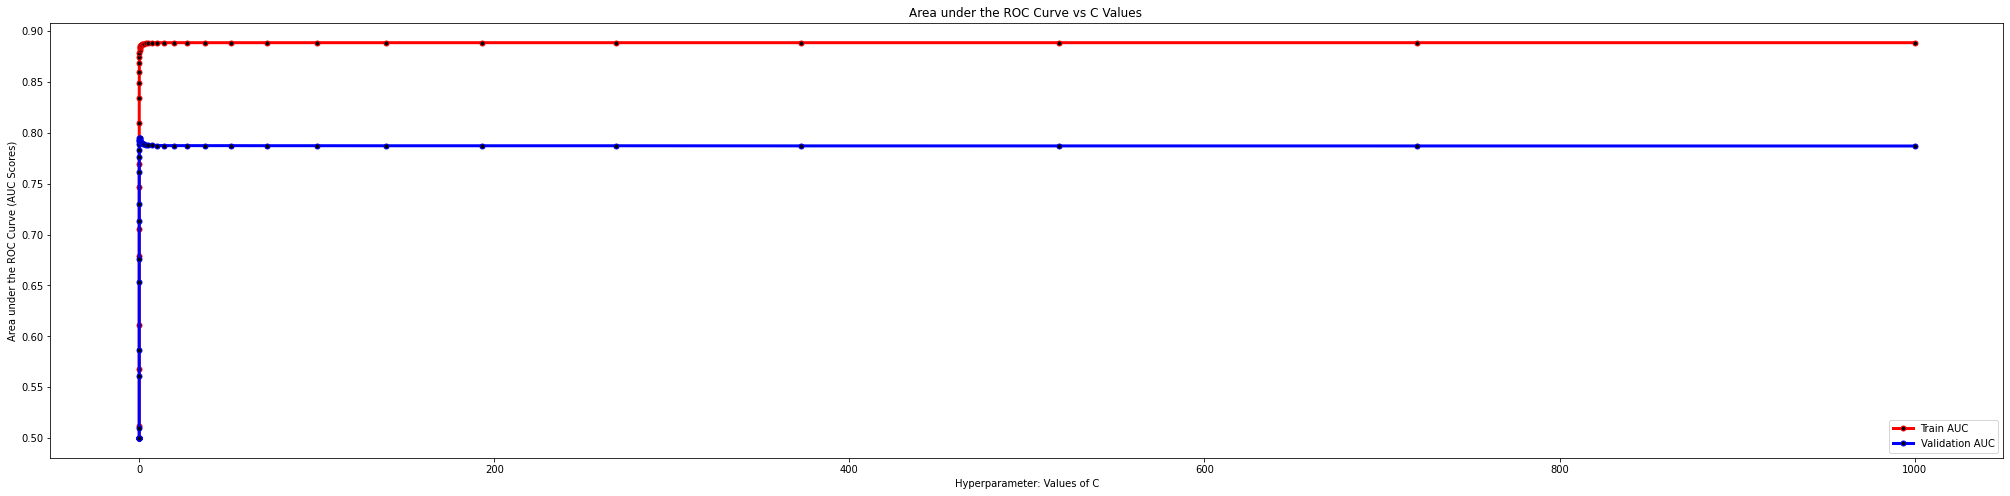

Time taken to complete grid search:  0:00:42.256515

'''PERFORMANCE EVALUATION for AVG-WORD-TO-VEC model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 3000 data points on unseen data for l1 regularization is 2620
Accuracy of the AVG-WORD-TO-VEC model using l1 regularization on unseen data is 87.33333333333333 %
Precision of the AVG-WORD-TO-VEC model using l1 regularization on unseen data is 0.9065
Recall of the AVG-WORD-TO-VEC model using l1 regularization on unseen data is 0.9519
F1 score of the AVG-WORD-TO-VEC model using l1 regularization on unseen data is 0.9286
AUC of the AVG-WORD-TO-VEC model using l1 regularization on unseen data is 0.835

Clasification report 
              precision    recall  f1-score   support

           0       0.54      0.37      0.44       403
           1       0.91      0.95      0.93      2597

    accuracy                           0.87      3000
   macro avg     

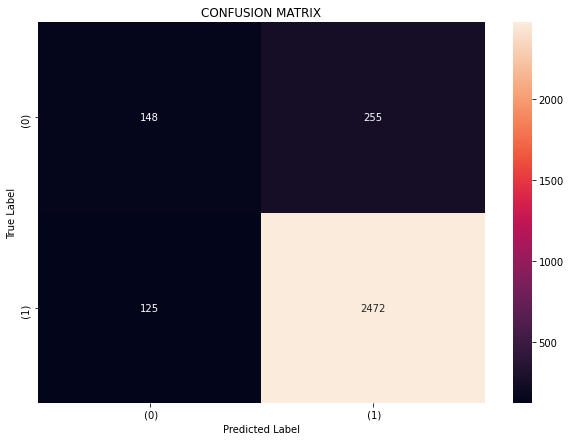

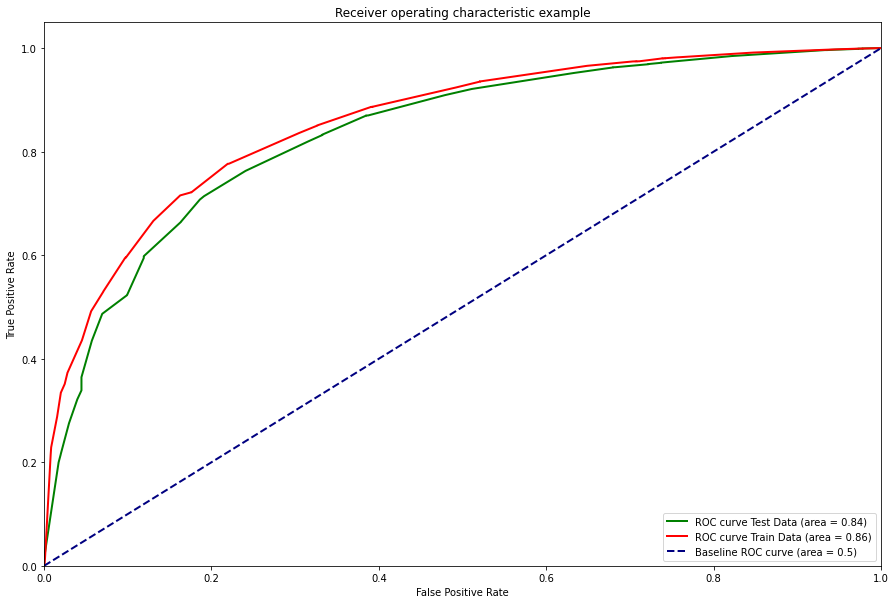

In [41]:
#Load the W2V Vectors we had created earlier and standardize them. We will standardize the traina and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_W2V.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_W2V.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_W2V.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_W2V.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_W2V.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_W2V.pkl', 'rb') as file:
    y_calib = pickle.load(file)    


print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, True)
X_test=standardize(X_test, True)
X_calib=standardize(X_calib, True)


#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_W2V_L1 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', 'AVG-WORD-TO-VEC', solver="liblinear")

#### Applying Logistic Regression with L2 regularization on AVG W2V,


USING L2 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS FOR AVG-WORD-TO-VEC MODEL. 
*******************************************************************************************************
Best estimator for l2 regularization : 
 LogisticRegression(C=0.007196856730011514, random_state=0)
Best Score for l2 regularization :  0.7977281499626994
The optimal value of C using l1 regularization is : 0.007196856730011514


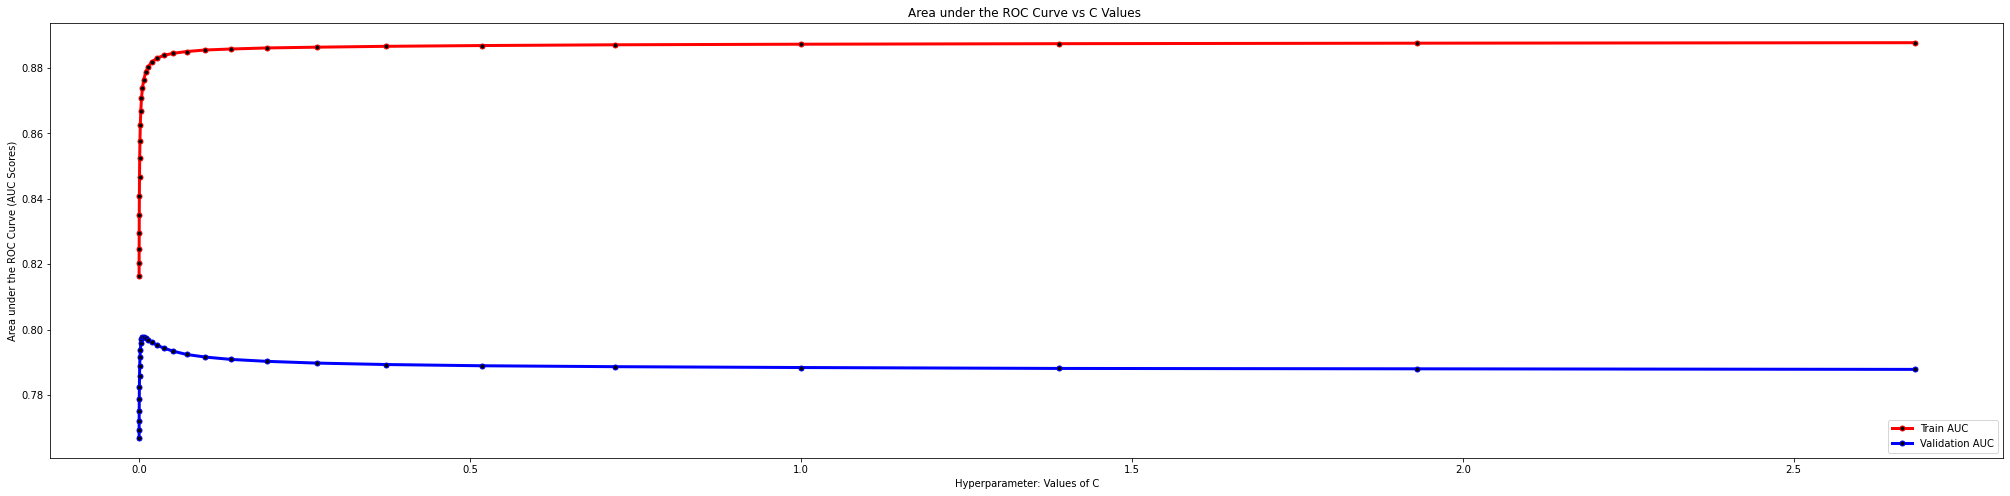

Time taken to complete grid search:  0:00:14.036873

'''PERFORMANCE EVALUATION for AVG-WORD-TO-VEC model using l2 regularization'''

Detailed report for Logistic regression using l2 regulaization

The number of accurate predictions out of 3000 data points on unseen data for l2 regularization is 2624
Accuracy of the AVG-WORD-TO-VEC model using l2 regularization on unseen data is 87.46666666666667 %
Precision of the AVG-WORD-TO-VEC model using l2 regularization on unseen data is 0.904
Recall of the AVG-WORD-TO-VEC model using l2 regularization on unseen data is 0.9569
F1 score of the AVG-WORD-TO-VEC model using l2 regularization on unseen data is 0.9297
AUC of the AVG-WORD-TO-VEC model using l2 regularization on unseen data is 0.8367

Clasification report 
              precision    recall  f1-score   support

           0       0.55      0.34      0.43       403
           1       0.90      0.96      0.93      2597

    accuracy                           0.87      3000
   macro avg     

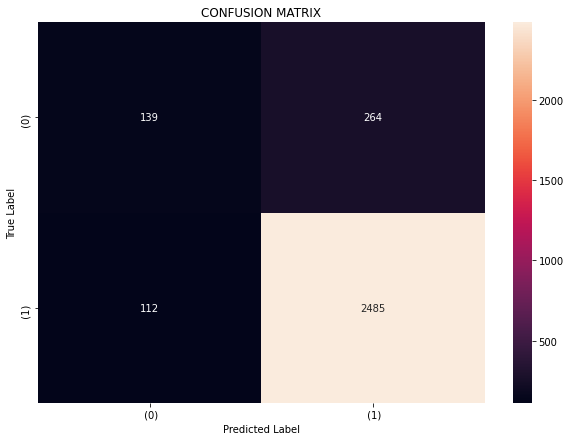

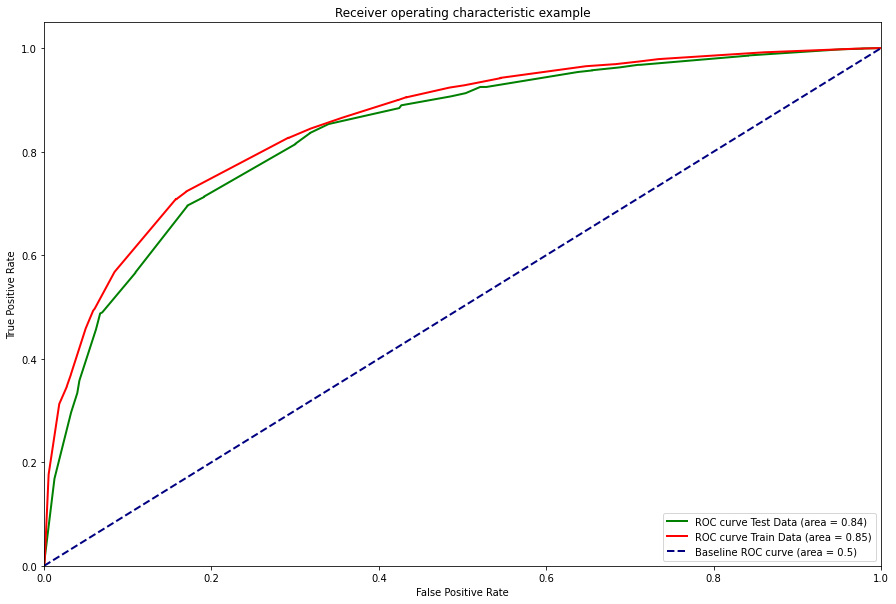

In [42]:
#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_W2V_L2 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', 'AVG-WORD-TO-VEC', solver="lbfgs")

### Logistic Regression on TFIDF W2V,
#### Applying Logistic Regression with L1 regularization on TFIDF W2V,

In [44]:
#Load the TF-IDF W2V Vectors we had created earlier and standardize them. We will standardize the train and test data seperately in order to prevent data leakage.
import pickle
    
with open('X_train_TFIDF-W2V.pkl', 'rb') as file:
    X_train = pickle.load(file)
with open('X_test_TFIDF-W2V.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_TFIDF-W2V.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_TFIDF-W2V.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_TFIDF-W2V.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_TFIDF-W2V.pkl', 'rb') as file:
    y_calib = pickle.load(file)    

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, True)
X_test=standardize(X_test, True)
X_calib=standardize(X_calib, True)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_TFIDF_W2V_L1 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', 'TFIDF-AVG-WORD-TO-VEC', solver="liblinear")

Shape of the train data matrix:  (10000, 200)
Shape of the test data matrix:  (3000, 200)
Shape of the calibration data matrix:  (4000, 200)

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS FOR TFIDF-AVG-WORD-TO-VEC MODEL. 
*******************************************************************************************************


KeyboardInterrupt: 

#### Applying Logistic Regression with L2 regularization on TFIDF W2V,

In [ ]:
#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_TFIDF_W2V_L2 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', 'TFIDF-AVG-WORD-TO-VEC', solver="lbfgs")

## Conclusions

In [45]:
#Compare performance and display it on a pretty table.
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", "Regularization", " Hyper-Parameter Value (C=)", "Accuracy on Unseen data", "AUC Score", "No. Of accurate predictions"]

print("Please find below the important metrics for all the models below.\n")
file = open('info_model_LR.txt', 'r')
file.seek(0)
for line in file:
    table.add_row(line.split())
print(table)


Please find below the important metrics for all the models below.

+-----------------+----------------+-----------------------------+-------------------------+-----------+-----------------------------+
|      Model      | Regularization |  Hyper-Parameter Value (C=) | Accuracy on Unseen data | AUC Score | No. Of accurate predictions |
+-----------------+----------------+-----------------------------+-------------------------+-----------+-----------------------------+
|   Bag-of-Words  |       l1       |            0.072            |    90.63333333333333    |   0.9189  |             2719            |
|   Bag-of-Words  |       l2       |            0.0004           |    91.10000000000001    |   0.9257  |             2733            |
|   Bag-of-Words  |       l2       |             0.01            |           90.4          |   0.907   |             2712            |
|      TF-IDF     |       l1       |            0.0373           |           91.5          |   0.9405  |             2745  


As we can see from the above table, TF-IDF representations gave us a slightly better AUC score than the rests (0.9405). However, by looking at the AUC curve we can see there's a difference of almost 5% in train and test AUCs. This shows there might be chances of underfitting. In case of both the Word2Vec models, the Accuracy values are nearly close to rest (87%). However, the train and test AUC curves almost exactly overlaps each other. This shows that our model is very robust.<br><br>

The highest AUC score as well as the highest accuracy obtained across all the above models is using TF-IDF representations using L2 regularization (i.e. Accuracy = 91.96% and AUC Score = 0.9326).<br><br>

Across the entire vocabulary we have obtained 6 features which can be said to be multi-colinear!

